In [1]:
import itertools as it
import os
import pandas as pd
import numpy as np
import random
import vitaldb
from pyvital.pyvital import arr
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import time, datetime
import neurokit2 as nk
from tqdm import tqdm

SRATE = 300
LEN_INPUT = 60
OVERLAP = 10
LEN_PER_PRE = 60
LEN_PER_POST = 60


# 피크 사이 wave를 모두 같은 length로 만들기 위한 함수
def linear_connection(list, idx):
    int_idx = int(idx)
    return list[int_idx] + (list[int_idx+1] - list[int_idx]) * (idx - int_idx)

def lowess(y, f=0.2):
    x = np.arange(0, len(y))
    return sm.nonparametric.lowess(y, x, frac=f, it=0)[:, 1].T
## 60초짜리 inputp에 대해 f 그려보기


print(datetime.datetime.now())

2022-12-04 10:31:37.761005


# Download Vital Data

In [2]:
SRATE = 500
file_path = f'vital_to_np_pd_{SRATE}Hz'

print('loading vital data...')
start = time.time()

# tracks to extract / VENT_SET_TV -> VENT_INSP_TM, SET_INSP_TM
track_names = ["SNUADC/ECG_II", "SNUADC/PLETH", "Solar8000/VENT_INSP_TM", "Primus/SET_INSP_TM", "Orchestra/PPF20_CE", "Orchestra/RFTN20_CE", "Solar8000/NIBP_MBP", "Solar8000/ART_MBP", "Solar8000/HR", "Solar8000/ETCO2"]

# create saving folder
#file_path = "vital_to_np"
if not os.path.exists(file_path):
    os.mkdir(file_path)

# dataframe of patient information    
df = pd.read_csv("https://api.vitaldb.net/cases")
df_trks = pd.read_csv("https://api.vitaldb.net/trks")

# target patients' caseids
caseids = list(vitaldb.caseids_tiva & 
               set(df.loc[df['ane_type'] == 'General', 'caseid']) & 
               set(df.loc[df['age'] > 18, 'caseid']) &
               set(df_trks.loc[df_trks['tname'] == 'Orchestra/RFTN20_CE', 'caseid']) &
               set(df_trks.loc[df_trks['tname'] == 'SNUADC/ECG_II', 'caseid']) &
               set(df_trks.loc[df_trks['tname'] == 'SNUADC/PLETH', 'caseid']))

print(f'survived caseids: {len(caseids)}/{len(df)}')


cnt = 0
non_intu, non_mbp, non_hr, non_rftn, emptyCO2 = [], [], [], [], []
pbar = tqdm(caseids)
for caseid in pbar:
    #cnt = cnt + 1
    #print(f'{cnt}/{len(caseids)}({caseid})', end='...')

    # check if file is already existing
    filename = f'{file_path}/{caseid}.npz'
    if os.path.isfile(filename):
        #print('already existing')
        continue


    # get vital file and save as numpy
    vf = vitaldb.VitalFile(caseid, track_names)
    vals = vf.to_numpy(track_names, interval=1/SRATE)

    
    # intubation time - find the first t which satisfies vent_set_tm != nan & ppf_ce != nan
    if not np.mean(~np.isnan(vals[:,5])) or len(vals[:,5]) == 0:
        non_rftn.append(caseid)
        #print('no valid data for rftn')
        continue

    t_intu = np.where(~np.isnan(vals[:,5]))[0][0]

    if not np.mean(~np.isnan(vals[:,2])):
        if not np.mean(~np.isnan(vals[:,3])):
            #print(f'no valid data for insp_tm')
            continue

        intu = vals[:,3]
        intv = 850 *(SRATE/100)  # maximum interval for "Primus/SET_INSP_TM"
    else:
        intu = vals[:,2]
        intv = 250 *(SRATE/100)  # maximum interval for "Solar8000/VENT_INSP_TM"

    idc_intu = np.where(~np.isnan(intu))[0]
    while True:
        if t_intu >= len(vals[:,0]):
            non_intu.append(caseid)
            #print('no valid intubation time')
            break

        # vent_insp_tm이 nan이 아닌 경우
        if not np.isnan(intu[t_intu]):
            idx = np.where(idc_intu==t_intu)[0][0]
            if idx + 10*(SRATE/100) >= len(idc_intu):
                non_intu.append(caseid)
                #print('...no valid intubation time')
                break                
            prev = t_intu

            # 모여있는 vent_insp_tm 길이 계산
            switch = True
            for i in range(1,11):
                if idc_intu[idx+i] - prev > intv:
                    switch = False
                prev = idc_intu[idx+i]

            if switch:
                break
                # 초반에 vent_insp_tm이 예외적으로 측정된 경우 제외    
                # if abs(t_intu-t_etco2) < 5.5*60*SRATE:
                #    break
                # else:
                #    t_intu += 1
            else:
                t_intu += 1
        else:
            t_intu += 1

    # Not enough data for input
    if t_intu - SRATE * 120 < 0:
        #print('no data from intubation - 120s')
        continue        
    
    
    # MBP value
    if not np.mean(~np.isnan(vals[:,6])):
        if not np.mean(~np.isnan(vals[:,7])):
            non_mbp.append(caseid)
            #print(f'no valid data for MBP')
    nibp = vals[:,6]
    art = vals[:,7]
    mbp = np.array([art[i] if art[i]>30 else nibp[i] for i in range(len(nibp))])

    # HR
    if not np.mean(~np.isnan(vals[:,8])):
        non_hr.append(caseid)
        #print('no valid data for HR')
    hr = vals[:,8]
    


        
    # non-event data : extract vital from previous 120s-60s from intubation
    ppg = vals[:,1]
    prev_ppg = ppg[t_intu - SRATE*120:t_intu - SRATE*60]

    ecg = vals[:,0]
    prev_ecg = ecg[t_intu - SRATE*120:t_intu - SRATE*60]

    nppf = vals[:,4]
    nppf = nppf[t_intu - SRATE*120:t_intu - SRATE*60]

    nrftn = vals[:,5]
    nrftn = nrftn[t_intu - SRATE*120:t_intu - SRATE*60]

    nmbp = mbp[t_intu - SRATE*120:t_intu - SRATE*60]
    nhr = hr[t_intu - SRATE*120:t_intu - SRATE*60]

    
    # after intubation, pain calculated using TSS, CISA
    post_ppg = ppg[t_intu:t_intu + SRATE*LEN_PER_POST]
    post_ecg = ecg[t_intu:t_intu + SRATE*LEN_PER_POST]

    ppf = vals[:,4]
    ppf = ppf[t_intu:t_intu + SRATE*LEN_PER_POST]

    rftn = vals[:,5]
    rftn = rftn[t_intu:t_intu + SRATE*LEN_PER_POST]

    embp = mbp[t_intu:t_intu + SRATE*LEN_PER_POST]
    ehr = hr[t_intu:t_intu + SRATE*LEN_PER_POST]
    
    np.savez(filename, nECG=prev_ecg, nPPG=prev_ppg, ECG=post_ecg, PPG=post_ppg, nPPF = nppf, nRFTN = nrftn, PPF=ppf, RFTN=rftn, nMBP=nmbp, MBP=embp, nHR=nhr, HR=ehr)
    #print('  completed')


end = time.time()
f = open(f'{file_path}/README.txt', 'w')
f.write(f'no valid intubation time: {non_intu}\n')
f.write(f'no valid MBP: {non_mbp}\n')
f.write(f'no valid HR: {non_hr}\n')
f.write(f'no valid RFTN: {non_rftn}\n')
#f.write(f'empty ETCO2: {emptyCO2}\n')
f.write(f'total time: {end-start:.2f} sec')
f.close()

loading vital data...
survived caseids: 2615/6388


100%|██████████| 2615/2615 [9:30:44<00:00, 13.10s/it]   


In [45]:
set(df_trks.loc[df_trks['tname'] == 'Orchestra/RFTN20_CE', 'caseid'])

{2,
 3,
 4,
 5,
 7,
 8,
 9,
 10,
 13,
 14,
 16,
 17,
 19,
 20,
 22,
 24,
 25,
 27,
 28,
 29,
 30,
 31,
 34,
 35,
 36,
 37,
 38,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 50,
 51,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 72,
 74,
 75,
 76,
 77,
 78,
 79,
 81,
 83,
 84,
 88,
 89,
 91,
 92,
 93,
 94,
 95,
 96,
 98,
 101,
 103,
 104,
 105,
 106,
 107,
 109,
 113,
 114,
 117,
 118,
 119,
 121,
 122,
 124,
 125,
 126,
 128,
 129,
 132,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 147,
 149,
 151,
 152,
 153,
 156,
 158,
 160,
 161,
 163,
 165,
 166,
 167,
 169,
 171,
 172,
 175,
 177,
 178,
 180,
 181,
 182,
 183,
 184,
 187,
 189,
 190,
 192,
 193,
 194,
 195,
 198,
 199,
 200,
 202,
 203,
 205,
 208,
 210,
 211,
 212,
 214,
 215,
 216,
 217,
 218,
 221,
 222,
 223,
 225,
 226,
 227,
 229,
 230,
 231,
 233,
 234,
 235,
 236,
 237,
 239,
 240,
 241,
 242,
 244,
 245,
 246,
 247,
 248,
 250,
 251,
 252,
 253,
 257,
 258,
 

In [65]:
len(vals[:,0])

1636691

# Preprocess

## Peak detection (depricated)
* 이제는 quality 평가할 때 peak도 같이 뽑음
* denoising 이후에 peak를 뽑음

In [5]:
print(datetime.datetime.now())
start = time.time()

# dataframe to save preprocessing info
column_list = ['caseid'] + ['1', '2']
df_preprocess = pd.DataFrame(columns = column_list)

# set variables
file_path = f'vital_to_np_pd_{SRATE}Hz'
caseids = os.listdir(file_path)

# create new folders
if not os.path.exists(f'cache/peaks/PPG_{SRATE}Hz_1min_seg'):
    os.mkdir(f'cache/peaks/PPG_{SRATE}Hz_1min_seg')
if not os.path.exists(f'cache/peaks/ECG_{SRATE}Hz_1min_seg'):
    os.mkdir(f'cache/peaks/ECG_{SRATE}Hz_1min_seg')

error_list, no_peaks = [], []
f_num = 0
initial, interval = f_num, len(caseids)
    

for caseid in caseids[initial:initial+interval]:
    caseid = caseid[:-4]
    f_num += 1
    print('\n###Input', f_num,'/ '+str(len(caseids))+': '+caseid+'###')


    # vital data 불러오기
    try:
        vals = np.load(f'{file_path}/{caseid}.npz')
    
    except Exception as e:
        continue


    #dataframe에 새로운 행 만들기
    df_preprocess.loc[f_num-1,'caseid'] = caseid

    ppg_cache = f"cache/peaks/PPG_{SRATE}Hz_1min_seg/" + caseid
    ecg_cache = f"cache/peaks/ECG_{SRATE}Hz_1min_seg/" + caseid    

    
    ### before intubation event (-120 ~ -60sec) preprocessing  
    for i in range(1):
        # vital data
        seg_ppg = vals['nPPG']
        seg_ecg = vals['nECG']

        ## 1. 결측치 제거 ##
        nan_ppg_perc = np.mean(np.isnan(seg_ppg))
        nan_ecg_perc = np.mean(np.isnan(seg_ecg))

        # segment의 결측치 비율 정보
        nan_info = [nan_ppg_perc, nan_ecg_perc]

        # 결측치가 많은 경우, noise 확인할 것도 없이 False -  이 경우의 noise_info는 -1로 처리
        if nan_ppg_perc > 0.05 or nan_ecg_perc > 0.05:
            print(' too much missing data', end='...')
            continue


        ## 2. Noise 처리 ##
        # peak detection
        if os.path.exists(ppg_cache+'_b60s'):
            _, ppg_peak = pickle.load(open(ppg_cache+'_b60s', 'rb'))
            ecg_peak = pickle.load(open(ecg_cache+'_b60s', 'rb'))
            print('...loaded peak...', end='')

        else:
            try:
                min_peak, ppg_peak = arr.detect_peaks(pd.DataFrame(seg_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), SRATE)
                signals, info = nk.ecg_peaks(pd.DataFrame(seg_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), sampling_rate = SRATE)
                ecg_peak = info["ECG_R_Peaks"]

            except Exception as e:
                print('error of', e)
                error_list.append(caseid)
                continue


            if len(ppg_peak)==0 or len(ecg_peak)==0:
                print('no peak')
                no_peaks.append(caseid)
                continue

            pickle.dump((min_peak, ppg_peak), open(ppg_cache+'_b60s', 'wb'))
            pickle.dump(ecg_peak, open(ecg_cache+'_b60s', 'wb'))
            print('...saved peak...', end='')


    ### after intubation event (0 ~ +60sec) preprocessing  
    for i in range(1):
        # vital data
        seg_ppg = vals['PPG']
        seg_ecg = vals['ECG']

        ## 1. 결측치 제거 ##
        nan_ppg_list = np.isnan(seg_ppg)
        nan_ecg_list = np.isnan(seg_ecg)
        nan_ppg_perc = np.sum(nan_ppg_list) / LEN_INPUT / SRATE
        nan_ecg_perc = np.sum(nan_ecg_list) / LEN_INPUT / SRATE

        # ECG, PPG 둘다 결측치인 부분
        nan_both_perc = 0
        for j in range(len(seg_ppg)):
            if nan_ppg_list[j] and  nan_ecg_list[j]:
                nan_both_perc += 1
        nan_both_perc /= (LEN_INPUT*SRATE)

        # segment의 결측치 비율 정보
        nan_info = [nan_ppg_perc, nan_ecg_perc, nan_both_perc]

        # 결측치가 많은 경우, noise 확인할 것도 없이 False -  이 경우의 noise_info는 -1로 처리
        if nan_ppg_perc > 0.05 or nan_ecg_perc > 0.05 or nan_both_perc > 0.05:
            print(' too much missing data', end='...')
            continue


        ## 2. Noise 처리 ##
        # peak detection
        if os.path.exists(ppg_cache+'_a60s'):
            _, ppg_peak = pickle.load(open(ppg_cache+'_a60s', 'rb'))
            ecg_peak = pickle.load(open(ecg_cache+'_a60s', 'rb'))
            print('...loaded peak...', end='')


        else:
            try:
                min_peak, ppg_peak = arr.detect_peaks(pd.DataFrame(seg_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), SRATE)
                signals, info = nk.ecg_peaks(pd.DataFrame(seg_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), sampling_rate = SRATE)
                ecg_peak = info["ECG_R_Peaks"]

            except Exception as e:
                print('error of', e)
                error_list.append(caseid)
                continue


            if len(ppg_peak)==0 or len(ecg_peak)==0:
                print('no peak')
                no_peaks.append(caseid)
                continue

            pickle.dump((min_peak, ppg_peak), open(ppg_cache+'_a60s', 'wb'))
            pickle.dump(ecg_peak, open(ecg_cache+'_a60s', 'wb'))
            print('...saved peak...', end='')
    
    
print(datetime.datetime.now())
print(f'total time : {time.time() - start:.3f} sec') 

2022-11-04 12:50:52.463564

###Input 1 / 2701: 5974###
...loaded peak......loaded peak...
###Input 2 / 2701: 801###
...loaded peak......loaded peak...
###Input 3 / 2701: 2790###
...loaded peak......loaded peak...
###Input 4 / 2701: 1413###
...loaded peak......loaded peak...
###Input 5 / 2701: 4057###
...loaded peak......loaded peak...
###Input 6 / 2701: 1698###
...loaded peak......loaded peak...
###Input 7 / 2701: 2084###
...loaded peak......loaded peak...
###Input 8 / 2701: 845###
...loaded peak......loaded peak...
###Input 9 / 2701: 83###
...loaded peak......loaded peak...
###Input 10 / 2701: 5976###
...loaded peak......loaded peak...
###Input 11 / 2701: 3923###
...loaded peak......loaded peak...
###Input 12 / 2701: 1349###
...loaded peak......loaded peak...
###Input 13 / 2701: 3907###
...loaded peak......loaded peak...
###Input 14 / 2701: 4108###
...loaded peak......loaded peak...
###Input 15 / 2701: 263###
...loaded peak......loaded peak...
###Input 16 / 2701: 4885###
...loaded pea

In [6]:
len(error_list), len(no_peaks)

(94, 0)

## Denoising

### Filter function

In [3]:
def ECG_filter(seg, method, srate):
    if method == '3rd-bandpass':
        import scipy.signal
        sos = scipy.signal.butter(3, [1,47], 'bandpass', output='sos', fs=srate)
        return scipy.signal.sosfilt(sos, seg)
    # lowess랑 수학적으로 동일한데 더 빠름 - 대신 계수 체크 필요
    if method == 'bandpass':
        import scipy.signal
        sos = scipy.signal.butter(5, [1,40], 'bandpass', output='sos', fs=srate)
        return scipy.signal.sosfilt(sos, seg)
    # lowess랑 수학적으로 동일한데 더 빠름 - 대신 계수 체크 필요
    elif method == 'savgol':
        import scipy.signal
        return seg - scipy.signal.savgol_filter(seg, 91, 3)
    
    elif method == 'lowess':
        import statsmodels.api as sm
        x = np.arange(0, len(seg))
        return seg - sm.nonparametric.lowess(seg, x, frac=0.2, it=0)[:, 1].T

    else:
        print('not a valid filter')
        return seg

    
def PPG_filter(seg, method, srate):
    if method == 'bandpass':
        import scipy.signal
        sos = scipy.signal.butter(3, [1,47], 'bandpass', output='sos', fs=srate)
        return scipy.signal.sosfilt(sos, seg)
    
    elif method == 'lowess':
        import statsmodels.api as sm
        x = np.arange(0, len(seg))
        return seg - sm.nonparametric.lowess(seg, x, frac=0.2, it=0)[:, 1].T
    
    else:
        print('not a valid filter')
        return seg

## Signal Quality Assessment

### Average coefficient method

In [28]:
def quality_assessment(seg_ppg, seg_ecg, corr_thres):
    # peak detection
    try:
        min_peak, ppg_peak = arr.detect_peaks(pd.DataFrame(seg_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), SRATE)
        signals, info = nk.ecg_peaks(pd.DataFrame(seg_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), sampling_rate = SRATE)
        ecg_peak = info["ECG_R_Peaks"]

    except Exception as e:
        #print('error of', e)
        return False
        
    if len(ppg_peak)==0 or len(ecg_peak)==0:
        #print('no peak')
        return False


    # segment 내의 ppg, ecg peak idx
    idx_ppg_peak = ppg_peak
    idx_ecg_peak = ecg_peak


    # peak가 HR 30~150 -> 20s - min 10 peaks(HR30)
    # peak 개수가 기준 미달이면 noise 계산 자세히 할 필요없이 False - 이 경우의 noise_info는 -2로 처리
    if len(idx_ppg_peak)<5/10*LEN_INPUT or len(idx_ecg_peak)<5/10*LEN_INPUT:
        #print(' too less peaks', end='')
        return False
    

    # peak와 peak 사이 interval에 대한 noise 여부 -> 따라서 길이는 peak - 1 (noise면 True)
    bool_noise_ppg = [False for k in range(len(idx_ppg_peak)-1)]
    bool_noise_ecg = [False for k in range(len(idx_ecg_peak)-1)]


    #  2.1 peak 간격 이상한 noise (HR 30~150 -> HBI 0.4s ~ 2s로 SRATE 곱해주면 40~200)
    for k in range(len(bool_noise_ppg)):
        if not 0.4*SRATE < idx_ppg_peak[k+1] - idx_ppg_peak[k] < 2*SRATE:
            bool_noise_ppg[k] = True
    for k in range(len(bool_noise_ecg)):
        if not 0.4*SRATE < idx_ecg_peak[k+1] - idx_ecg_peak[k] < 2*SRATE:
            bool_noise_ecg[k] = True


    # 2.2 모양 이상한 noise
    # wave interval into same length(2s(200))
    len_wave = 2*SRATE
    norm_seg_ppg, norm_seg_ecg = [], []

    for k in range(len(bool_noise_ppg)):
        len_interval_ppg = idx_ppg_peak[k+1] - idx_ppg_peak[k]
        # peak 사이 wave를 모두 같은 길이로 변환
        norm_seg_ppg.append([linear_connection(seg_ppg[idx_ppg_peak[k]:idx_ppg_peak[k+1]+1], n/len_wave*len_interval_ppg) for n in range(len_wave)])

    for k in range(len(bool_noise_ecg)):
        len_interval_ecg = idx_ecg_peak[k+1] - idx_ecg_peak[k]
        # peak 사이 wave를 모두 같은 길이로 변환
        norm_seg_ecg.append([linear_connection(seg_ecg[idx_ecg_peak[k]:idx_ecg_peak[k+1]+1], n/len_wave*len_interval_ecg) for n in range(len_wave)])

    # wave interval 사이 correlation 계산 - PPG
    corr_ppg = []
    mean_wave_ppg = np.nanmean(norm_seg_ppg, axis = 0)
    mean_wave_ppg = pd.DataFrame(mean_wave_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
    norm_seg_ppg = pd.DataFrame(norm_seg_ppg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
    for k in range(len(bool_noise_ppg)):
        corr = np.corrcoef(norm_seg_ppg[k], mean_wave_ppg)[0,1]
        corr_ppg.append(corr)
    noise_ppg_perc = np.mean(bool_noise_ppg | (np.array(corr_ppg) < corr_thres))


    # wave interval 사이 correlation 계산 - ECG   
    corr_ecg = []
    mean_wave_ecg = np.nanmean(norm_seg_ecg, axis = 0)
    mean_wave_ecg = pd.DataFrame(mean_wave_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
    norm_seg_ecg = pd.DataFrame(norm_seg_ecg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
    for k in range(len(bool_noise_ecg)):
        corr = np.corrcoef(norm_seg_ecg[k], mean_wave_ecg)[0,1]
        corr_ecg.append(corr)
    noise_ecg_perc = np.mean(bool_noise_ecg | (np.array(corr_ecg) < corr_thres))                          

    
    # segment의 noise 비율 정보를 return
    return [noise_ppg_perc, noise_ecg_perc]

* 기존 원본

In [ ]:
# path for cache
if not os.path.exists('./cache'):
    os.mkdir('./cache')
if not os.path.exists('./cache/peaks'):
    os.mkdir('./cache/peaks')
if not os.path.exists(f"cache/peaks/PPG_{SRATE}Hz_1min_seg"):
    os.mkdir(f"cache/peaks/PPG_{SRATE}Hz_1min_seg")
if not os.path.exists(f"cache/peaks/ECG_{SRATE}Hz_1min_seg"):
    os.mkdir(f"cache/peaks/ECG_{SRATE}Hz_1min_seg")        
if not os.path.exists('./cache/preprocess'):
    os.mkdir('./cache/preprocess')


# dataframe to save preprocessing info
column_list = ['caseid'] + ['1', '2']
df_preprocess = pd.DataFrame(columns = column_list)


# set variables
caseids = os.listdir(file_path)
error_list = []
f_num = 0
initial = f_num
interval = len(caseids)

  
for caseid in caseids[initial:initial+interval]:
    caseid = caseid[:-4]
    f_num += 1
    print('\n###Input', f_num,'/ '+str(len(caseids))+': '+caseid+'###')


    # vital data 불러오기    
    vals = np.load(f'{file_path}/{caseid}.npz')

    if not np.mean(~np.isnan(vals['RFTN'])):
        print('no RFTN value')
        continue

    #dataframe에 새로운 행 만들기
    df_preprocess.loc[f_num-1,'caseid'] = caseid

    ppg_cache = f"cache/peaks/PPG_{SRATE}Hz_1min_seg/" + caseid
    ecg_cache = f"cache/peaks/ECG_{SRATE}Hz_1min_seg/" + caseid    
    ecg_cache2 = f"cache/peaks/ECG_{SRATE}Hz_1min_seg/" + caseid

    
    ### before intubation event (-120 ~ -60sec) preprocessing  
    for i in range(1):
        seg_ppg = vals['nPPG']
        seg_ecg = vals['nECG']

        ## 1. 결측치 ##
        nan_ppg_list = np.isnan(seg_ppg)
        nan_ecg_list = np.isnan(seg_ecg)
        nan_ppg_perc = np.sum(nan_ppg_list) / LEN_INPUT / SRATE
        nan_ecg_perc = np.sum(nan_ecg_list) / LEN_INPUT / SRATE


        # ECG, PPG 둘다 결측치인 부분
        nan_both_perc = 0
        for j in range(len(seg_ppg)):
            if nan_ppg_list[j] and  nan_ecg_list[j]:
                nan_both_perc += 1
        nan_both_perc /= (LEN_INPUT*SRATE)

        # segment의 결측치 비율 정보
        nan_info = [nan_ppg_perc, nan_ecg_perc, nan_both_perc]


        # 결측치가 많은 경우, noise 확인할 것도 없이 False -  이 경우의 noise_info는 -1로 처리
        if nan_ppg_perc > 0.05 or nan_ecg_perc > 0.05 or nan_both_perc > 0.05:
            df_preprocess.loc[f_num-1,'1'] = (False, nan_info, [-1, -1])
            print(' too much missing data', end='...')
            continue

        ## 2. Denosing ##
        # ECG : 1-40Hz bandpass filter
        x = pd.DataFrame(seg_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        sos = scipy.signal.butter(5, [1,40], 'bandpass', output='sos', fs=SRATE)
        seg_ecg = scipy.signal.sosfilt(sos, x)
        
        # PPG : loess filter
        seg_ppg = seg_ppg - lowess(pd.DataFrame(seg_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten())
            

        ## 3. Quality Assessment ##  -> def 함수로 처리?
        # peak detection
        if os.path.exists(ppg_cache+'_b60s'):
            _, ppg_peak = pickle.load(open(ppg_cache+'_b60s', 'rb'))
            ecg_peak = pickle.load(open(ecg_cache+'_b60s', 'rb'))
            print('...loaded peak...', end='')

        else:
            try:
                min_peak, ppg_peak = arr.detect_peaks(pd.DataFrame(seg_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), SRATE)
                signals, info = nk.ecg_peaks(pd.DataFrame(seg_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), sampling_rate = SRATE)
                ecg_peak = info["ECG_R_Peaks"]

            except Exception as e:
                print('error of', e)
                error_list.append(caseid)
                df_preprocess.loc[f_num-1,'1'] = (False, nan_info, [-3, -3])
                continue


            if len(ppg_peak)==0:
                print('no peak')

            pickle.dump((min_peak, ppg_peak), open(ppg_cache+'_b60s', 'wb'))
            pickle.dump(ecg_peak, open(ecg_cache+'_b60s', 'wb'))
            print('...saved peak...', end='')


        # 10초 segment 내의 ppg, ecg peak idx
        #seg_ppg_min = ppg_min[(start_idx<=np.array(ppg_min)) & (np.array(ppg_min)<end_idx)]
        idx_ppg_peak = ppg_peak
        idx_ecg_peak = ecg_peak


        # peak가 HR 30~150 -> 20s - min 10 peaks(HR30)
        # peak 개수가 기준 미달이면 noise 계산 자세히 할 필요없이 False - 이 경우의 noise_info는 -2로 처리
        if len(idx_ppg_peak)<5/10*LEN_INPUT or len(idx_ecg_peak)<5/10*LEN_INPUT:
            df_preprocess.loc[f_num-1,'1'] = (False, nan_info, [-2, -2])
            print(' too less peaks', end='')
            continue


        # 20초 segment 내의 ppg, ecg peak value
        #print(len(seg_ppg), idx_ppg_peak)
        val_ppg_peak = [seg_ppg[k] for k in idx_ppg_peak]
        val_ecg_peak = [seg_ecg[k] for k in idx_ecg_peak]

        # peak와 peak 사이 interval에 대한 noise 여부 -> 따라서 길이는 peak - 1
        bool_noise_ppg = [False for k in range(len(idx_ppg_peak)-1)]
        bool_noise_ecg = [False for k in range(len(idx_ecg_peak)-1)]


        #  2.1 peak 간격 이상한 noise (HR 30~150 -> HBI 0.4s ~ 2s로 SRATE 곱해주면 40~200)
        for k in range(len(bool_noise_ppg)):
            if not 0.4*SRATE < idx_ppg_peak[k+1] - idx_ppg_peak[k] < 2*SRATE:
                bool_noise_ppg[k] = True
        for k in range(len(bool_noise_ecg)):
            if not 0.4*SRATE < idx_ecg_peak[k+1] - idx_ecg_peak[k] < 2*SRATE:
                bool_noise_ecg[k] = True


        # 2.2 모양 이상한 noise
        # wave interval into same length(2s(200))
        len_wave = 2*SRATE
        norm_seg_ppg, norm_seg_ecg = [], []

        for k in range(len(bool_noise_ppg)):
            len_interval_ppg = idx_ppg_peak[k+1] - idx_ppg_peak[k]

            # peak 사이 wave를 모두 같은 길이로 변환
            norm_seg_ppg.append([linear_connection(seg_ppg[idx_ppg_peak[k]:idx_ppg_peak[k+1]+1], n/len_wave*len_interval_ppg) for n in range(len_wave)])

        for k in range(len(bool_noise_ecg)):
            len_interval_ecg = idx_ecg_peak[k+1] - idx_ecg_peak[k]

            # peak 사이 wave를 모두 같은 길이로 변환
            norm_seg_ecg.append([linear_connection(seg_ecg[idx_ecg_peak[k]:idx_ecg_peak[k+1]+1], n/len_wave*len_interval_ecg) for n in range(len_wave)])


        # wave interval 사이 correlation 계산 - PPG
        mean_wave_ppg = np.nanmean(norm_seg_ppg, axis = 0)
        mean_wave_ppg = pd.DataFrame(mean_wave_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        norm_seg_ppg = pd.DataFrame(norm_seg_ppg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
        for k in range(len(bool_noise_ppg)):
            if np.corrcoef(norm_seg_ppg[k], mean_wave_ppg)[0,1] < 0.9:
                bool_noise_ppg[k] = True
        noise_ppg_perc = np.sum(bool_noise_ppg) / len(bool_noise_ppg)

        # wave interval 사이 correlation 계산 - ECG                
        mean_wave_ecg = np.nanmean(norm_seg_ecg, axis = 0)
        mean_wave_ecg = pd.DataFrame(mean_wave_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        norm_seg_ecg = pd.DataFrame(norm_seg_ecg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
        for k in range(len(bool_noise_ecg)):
            if np.corrcoef(norm_seg_ecg[k], mean_wave_ecg)[0,1] < 0.9:
                bool_noise_ecg[k] = True
        noise_ecg_perc = np.sum(bool_noise_ecg) / len(bool_noise_ecg)

        # segment의 noise 비율 정보
        noise_info = [noise_ppg_perc, noise_ecg_perc]

        # segment를 input으로 써도 되는지
        if nan_ppg_perc < 0.05 and nan_ecg_perc < 0.05 and nan_both_perc < 0.05 and noise_ppg_perc < 0.1 and noise_ecg_perc < 0.1:
            bool_pass = True
        else:
            bool_pass = False

        # 이 segment의 정보를 dataframe에 저장 - (전처리 성공여부, 전처리 nan 비율, 전처리 noise 비율, 통증 점수)
        arry = np.empty(1, dtype=object)
        arry[0] = [bool_pass, nan_info, noise_info]
        df_preprocess.loc[f_num-1,'1'] = arry[0] #{'pass':bool_pass, 'nan_perc':nan_info, 'noise_perc':noise_info, 'tss':0, 'cisa':0}        
        print('preprocessing done...', end='')
    ##########################################################################


    ### after intubation event (0 ~ +60sec) preprocessing  
    for i in range(1):
        seg_ppg = vals['PPG']
        seg_ecg = vals['ECG']

        nan_ppg_list = np.isnan(seg_ppg)
        nan_ecg_list = np.isnan(seg_ecg)
        nan_ppg_perc = np.sum(nan_ppg_list) / LEN_INPUT / SRATE
        nan_ecg_perc = np.sum(nan_ecg_list) / LEN_INPUT / SRATE


        # ECG, PPG 둘다 결측치인 부분
        nan_both_perc = 0
        for j in range(len(seg_ppg)):
            if nan_ppg_list[j] and  nan_ecg_list[j]:
                nan_both_perc += 1
        nan_both_perc /= (LEN_INPUT*SRATE)

        # segment의 결측치 비율 정보
        nan_info = [nan_ppg_perc, nan_ecg_perc, nan_both_perc]


        # 결측치가 많은 경우, noise 확인할 것도 없이 False -  이 경우의 noise_info는 -1로 처리
        if nan_ppg_perc > 0.05 or nan_ecg_perc > 0.05 or nan_both_perc > 0.05:
            df_preprocess.loc[f_num-1,'2'] = (False, nan_info, [-1, -1])
            print(' too much missing data', end='...')
            continue


        ## 2. Noise 처리 ##
        # peak detection (b60s : before 60s)
        if os.path.exists(ppg_cache+'_a60s'):
            _, ppg_peak = pickle.load(open(ppg_cache+'_a60s', 'rb'))
            ecg_peak = pickle.load(open(ecg_cache+'_a60s', 'rb'))
            print('...loaded peak...', end='')


        else:
            try:
                min_peak, ppg_peak = arr.detect_peaks(pd.DataFrame(seg_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), SRATE)
                signals, info = nk.ecg_peaks(pd.DataFrame(seg_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), sampling_rate = SRATE)
                ecg_peak = info["ECG_R_Peaks"]


            except Exception as e:
                print('error of', e)
                error_list.append(caseid)
                df_preprocess.loc[f_num-1,'2'] = (False, nan_info, [-3, -3])
                continue


            if len(ppg_peak)==0:
                print('no peak')


            pickle.dump((min_peak, ppg_peak), open(ppg_cache+'_a60s', 'wb'))
            pickle.dump(ecg_peak, open(ecg_cache+'_a60s', 'wb'))
            print('...saved peak...', end='')


        # 10초 segment 내의 ppg, ecg peak idx
        #seg_ppg_min = ppg_min[(start_idx<=np.array(ppg_min)) & (np.array(ppg_min)<end_idx)]
        idx_ppg_peak = ppg_peak
        idx_ecg_peak = ecg_peak


        # peak가 HR 30~150 -> 20s - min 10 peaks(HR30)
        # peak 개수가 기준 미달이면 noise 계산 자세히 할 필요없이 False - 이 경우의 noise_info는 -2로 처리
        if len(idx_ppg_peak)<5/10*LEN_INPUT or len(idx_ecg_peak)<5/10*LEN_INPUT:
            df_preprocess.loc[f_num-1,'2'] = (False, nan_info, [-2, -2])
            print(' too less peaks', end='')
            continue


        # 20초 segment 내의 ppg, ecg peak value
        #print(len(seg_ppg), idx_ppg_peak)
        val_ppg_peak = [seg_ppg[k] for k in idx_ppg_peak]
        val_ecg_peak = [seg_ecg[k] for k in idx_ecg_peak]

        # peak와 peak 사이 interval에 대한 noise 여부 -> 따라서 길이는 peak - 1
        bool_noise_ppg = [False for k in range(len(idx_ppg_peak)-1)]
        bool_noise_ecg = [False for k in range(len(idx_ecg_peak)-1)]


        #  2.1 peak 간격 이상한 noise (HR 30~150 -> HBI 0.4s ~ 2s로 SRATE 곱해주면 40~200)
        for k in range(len(bool_noise_ppg)):
            if not 0.4*SRATE < idx_ppg_peak[k+1] - idx_ppg_peak[k] < 2*SRATE:
                bool_noise_ppg[k] = True
        for k in range(len(bool_noise_ecg)):
            if not 0.4*SRATE < idx_ecg_peak[k+1] - idx_ecg_peak[k] < 2*SRATE:
                bool_noise_ecg[k] = True


        # 2.2 모양 이상한 noise
        # wave interval into same length(2s(200))
        len_wave = 2*SRATE
        norm_seg_ppg, norm_seg_ecg = [], []

        for k in range(len(bool_noise_ppg)):
            len_interval_ppg = idx_ppg_peak[k+1] - idx_ppg_peak[k]

            # peak 사이 wave를 모두 같은 길이로 변환
            norm_seg_ppg.append([linear_connection(seg_ppg[idx_ppg_peak[k]:idx_ppg_peak[k+1]+1], n/len_wave*len_interval_ppg) for n in range(len_wave)])

        for k in range(len(bool_noise_ecg)):
            len_interval_ecg = idx_ecg_peak[k+1] - idx_ecg_peak[k]

            # peak 사이 wave를 모두 같은 길이로 변환
            norm_seg_ecg.append([linear_connection(seg_ecg[idx_ecg_peak[k]:idx_ecg_peak[k+1]+1], n/len_wave*len_interval_ecg) for n in range(len_wave)])


        # wave interval 사이 correlation 계산 - PPG
        mean_wave_ppg = np.nanmean(norm_seg_ppg, axis = 0)
        mean_wave_ppg = pd.DataFrame(mean_wave_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        norm_seg_ppg = pd.DataFrame(norm_seg_ppg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
        for k in range(len(bool_noise_ppg)):
            if np.corrcoef(norm_seg_ppg[k], mean_wave_ppg)[0,1] < 0.9:
                bool_noise_ppg[k] = True
        noise_ppg_perc = np.sum(bool_noise_ppg) / len(bool_noise_ppg)

        # wave interval 사이 correlation 계산 - ECG                
        mean_wave_ecg = np.nanmean(norm_seg_ecg, axis = 0)
        mean_wave_ecg = pd.DataFrame(mean_wave_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        norm_seg_ecg = pd.DataFrame(norm_seg_ecg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
        for k in range(len(bool_noise_ecg)):
            if np.corrcoef(norm_seg_ecg[k], mean_wave_ecg)[0,1] < 0.9:
                bool_noise_ecg[k] = True
        noise_ecg_perc = np.sum(bool_noise_ecg) / len(bool_noise_ecg)

        # segment의 noise 비율 정보
        noise_info = [noise_ppg_perc, noise_ecg_perc]

        # segment를 input으로 써도 되는지
        if nan_ppg_perc < 0.05 and nan_ecg_perc < 0.05 and nan_both_perc < 0.05 and noise_ppg_perc < 0.1 and noise_ecg_perc < 0.1:
            bool_pass = True
        else:
            bool_pass = False

        # 이 segment의 정보를 dataframe에 저장 - (전처리 성공여부, 전처리 nan 비율, 전처리 noise 비율, 통증 점수)
        arry = np.empty(1, dtype=object)
        arry[0] = [bool_pass, nan_info, noise_info]
        df_preprocess.loc[f_num-1,'2'] = arry[0] #{'pass':bool_pass, 'nan_perc':nan_info, 'noise_perc':noise_info, 'tss':0, 'cisa':0}        
        print('preprocessing done...', end='')
    
         

print(f'\ndumping cache of df_preprocess {f_num}/{len(caseids)}', end='...')

# df_preprocess에 demographs(age, gender) 추가
df_demograph = pd.read_csv("https://api.vitaldb.net/cases")
df_preprocess['age'] = np.nan
df_preprocess['gender'] = np.nan

for idx, row in df_preprocess.iterrows():     
    row_demo = df_demograph[df_demograph['caseid']==int(row['caseid'])]

    df_preprocess.loc[idx, 'age'] = row_demo['age'].values[0]
    df_preprocess.loc[idx, 'gender'] = row_demo['sex'].values[0]

df_preprocess.reset_index(drop=True, inplace=True)    
pickle.dump(df_preprocess, open('cache/preprocess/df_preprocess_60s', 'wb'))
print('dumping success')

# 전처리 통과 비율 출력
nl_pass, l_pass = [], []
for idx, row in df_preprocess.iterrows():
    nl_pass.append(row['1'][0])
    l_pass.append(row['2'][0])
    
print(f'전처리 성공 비율 : intubation 직전 {np.mean(nl_pass)*100:.2f}%, intubation 직후 {np.mean(l_pass)*100:.2f}%')
print(datetime.datetime.now())

* Full version

In [ ]:
SRATE = 300
NOISE_THRES = 0.85


# path for cache
if not os.path.exists('./cache'):
    os.mkdir('./cache')
if not os.path.exists('./cache/peaks'):
    os.mkdir('./cache/peaks')
if not os.path.exists(f"cache/peaks/PPG_{SRATE}Hz_1min_seg"):
    os.mkdir(f"cache/peaks/PPG_{SRATE}Hz_1min_seg")
if not os.path.exists(f"cache/peaks/ECG_{SRATE}Hz_1min_seg"):
    os.mkdir(f"cache/peaks/ECG_{SRATE}Hz_1min_seg")        
if not os.path.exists('./cache/preprocess'):
    os.mkdir('./cache/preprocess')


# dataframe to save preprocessing info
column_list = ['caseid'] + ['1', '2']
df_preprocess = pd.DataFrame(columns = column_list)


# set variables
caseids = os.listdir(file_path)
error_list = []
f_num = 0
initial, interval = f_num, len(caseids)

  
for caseid in caseids[initial:initial+interval]:
    caseid = caseid[:-4]   # '123.npz' -> '123'
    f_num += 1
    print('\n###Input', f_num,'/ '+str(len(caseids))+': '+caseid+'###')


    # vital data 불러오기
    try:
        vals = np.load(f'{file_path}/{caseid}.npz')
    
    except Exception as e:
        continue


    #dataframe에 새로운 행 만들기
    df_preprocess.loc[f_num-1,'caseid'] = caseid

    ppg_cache = f"cache/peaks/PPG_{SRATE}Hz_1min_seg/" + caseid
    ecg_cache = f"cache/peaks/ECG_{SRATE}Hz_1min_seg/" + caseid    

    
    ### before intubation event (-120 ~ -60sec) preprocessing  
    for i in range(1):
        # vital data
        seg_ppg = vals['nPPG']
        seg_ecg = vals['nECG']

        ## 1. 결측치 제거 ##
        nan_ppg_perc = np.mean(np.isnan(seg_ppg))
        nan_ecg_perc = np.mean(np.isnan(seg_ecg))

        # segment의 결측치 비율 정보
        nan_info = [nan_ppg_perc, nan_ecg_perc]

        # 결측치가 많은 경우, noise 확인할 것도 없이 False -  이 경우의 noise_info는 -1로 처리
        if nan_ppg_perc > 0.05 or nan_ecg_perc > 0.05:
            print(' too much missing data', end='...')
            continue


        ## 2. Denosing ##
        # ECG : 1-40Hz bandpass filter / PPG : loess filter
        seg_ecg = ECG_filter(pd.DataFrame(seg_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), method='bandpass', srate=SRATE)
        seg_ppg = PPG_filter(pd.DataFrame(seg_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), method='lowess', srate=SRATE)
            

        ## 3. Quality Assessment ##  -> def 함수로 처리?
        # peak detection
        try:
            min_peak, ppg_peak = arr.detect_peaks(pd.DataFrame(seg_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), SRATE)
            signals, info = nk.ecg_peaks(pd.DataFrame(seg_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), sampling_rate = SRATE)
            ecg_peak = info["ECG_R_Peaks"]

        except Exception as e:
            print('error of', e)
            error_list.append(caseid)
            df_preprocess.loc[f_num-1,'1'] = (False, nan_info, [-3, -3])
            continue

        if len(ppg_peak)==0 or len(ecg_peak)==0:
            print('no peak')
            no_peaks.append(caseid)
            continue


        # 10초 segment 내의 ppg, ecg peak idx
        #seg_ppg_min = ppg_min[(start_idx<=np.array(ppg_min)) & (np.array(ppg_min)<end_idx)]
        idx_ppg_peak = ppg_peak
        idx_ecg_peak = ecg_peak


        # peak가 HR 30~150 -> 20s - min 10 peaks(HR30)
        # peak 개수가 기준 미달이면 noise 계산 자세히 할 필요없이 False - 이 경우의 noise_info는 -2로 처리
        if len(idx_ppg_peak)<5/10*LEN_INPUT or len(idx_ecg_peak)<5/10*LEN_INPUT:
            df_preprocess.loc[f_num-1,'1'] = (False, nan_info, [-2, -2])
            print(' too less peaks', end='')
            continue


        # 20초 segment 내의 ppg, ecg peak value
        #print(len(seg_ppg), idx_ppg_peak)
        val_ppg_peak = [seg_ppg[k] for k in idx_ppg_peak]
        val_ecg_peak = [seg_ecg[k] for k in idx_ecg_peak]

        # peak와 peak 사이 interval에 대한 noise 여부 -> 따라서 길이는 peak - 1 (noise면 True)
        bool_noise_ppg = [False for k in range(len(idx_ppg_peak)-1)]
        bool_noise_ecg = [False for k in range(len(idx_ecg_peak)-1)]


        #  2.1 peak 간격 이상한 noise (HR 30~150 -> HBI 0.4s ~ 2s로 SRATE 곱해주면 40~200)
        for k in range(len(bool_noise_ppg)):
            if not 0.4*SRATE < idx_ppg_peak[k+1] - idx_ppg_peak[k] < 2*SRATE:
                bool_noise_ppg[k] = True
        for k in range(len(bool_noise_ecg)):
            if not 0.4*SRATE < idx_ecg_peak[k+1] - idx_ecg_peak[k] < 2*SRATE:
                bool_noise_ecg[k] = True


        # 2.2 모양 이상한 noise
        # wave interval into same length(2s(200))
        len_wave = 2*SRATE
        norm_seg_ppg, norm_seg_ecg = [], []

        for k in range(len(bool_noise_ppg)):
            len_interval_ppg = idx_ppg_peak[k+1] - idx_ppg_peak[k]

            # peak 사이 wave를 모두 같은 길이로 변환
            norm_seg_ppg.append([linear_connection(seg_ppg[idx_ppg_peak[k]:idx_ppg_peak[k+1]+1], n/len_wave*len_interval_ppg) for n in range(len_wave)])

        for k in range(len(bool_noise_ecg)):
            len_interval_ecg = idx_ecg_peak[k+1] - idx_ecg_peak[k]

            # peak 사이 wave를 모두 같은 길이로 변환
            norm_seg_ecg.append([linear_connection(seg_ecg[idx_ecg_peak[k]:idx_ecg_peak[k+1]+1], n/len_wave*len_interval_ecg) for n in range(len_wave)])


        # wave interval 사이 correlation 계산 - PPG
        corr_ppg = []
        mean_wave_ppg = np.nanmean(norm_seg_ppg, axis = 0)
        mean_wave_ppg = pd.DataFrame(mean_wave_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        norm_seg_ppg = pd.DataFrame(norm_seg_ppg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
        for k in range(len(bool_noise_ppg)):
            corr = np.corrcoef(norm_seg_ppg[k], mean_wave_ppg)[0,1]
            corr_ppg.append(corr)
        noise_ppg_perc = np.mean(bool_noise_ppg | (np.array(corr_ppg) < NOISE_THRES))


        # wave interval 사이 correlation 계산 - ECG   
        corr_ecg = []
        mean_wave_ecg = np.nanmean(norm_seg_ecg, axis = 0)
        mean_wave_ecg = pd.DataFrame(mean_wave_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        norm_seg_ecg = pd.DataFrame(norm_seg_ecg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
        for k in range(len(bool_noise_ecg)):
            corr = np.corrcoef(norm_seg_ecg[k], mean_wave_ecg)[0,1]
            corr_ecg.append(corr)
        noise_ecg_perc = np.mean(bool_noise_ecg | (np.array(corr_ecg) < NOISE_THRES))                          

                                 
        # segment의 noise 비율 정보
        noise_info = [noise_ppg_perc, noise_ecg_perc]

        # segment를 input으로 써도 되는지
        if nan_ppg_perc < 0.05 and nan_ecg_perc < 0.05 and nan_both_perc < 0.05 and noise_ppg_perc < 0.1 and noise_ecg_perc < 0.1:
            bool_pass = True
        else:
            bool_pass = False

        # 이 segment의 정보를 dataframe에 저장 - (전처리 성공여부, 전처리 nan 비율, 전처리 noise 비율, 통증 점수)
        arry = np.empty(1, dtype=object)
        arry[0] = [bool_pass, nan_info, noise_info]
        df_preprocess.loc[f_num-1,'1'] = arry[0] #{'pass':bool_pass, 'nan_perc':nan_info, 'noise_perc':noise_info, 'tss':0, 'cisa':0}        
        print('preprocessing done...', end='')
    ##########################################################################


    ### after intubation event (0 ~ +60sec) preprocessing  
    for i in range(1):
        seg_ppg = vals['PPG']
        seg_ecg = vals['ECG']

        ## 1. 결측치 제거 ##
        nan_ppg_perc = np.mean(np.isnan(seg_ppg))
        nan_ecg_perc = np.mean(np.isnan(seg_ecg))

        # segment의 결측치 비율 정보
        nan_info = [nan_ppg_perc, nan_ecg_perc]

        # 결측치가 많은 경우, noise 확인할 것도 없이 False -  이 경우의 noise_info는 -1로 처리
        if nan_ppg_perc > 0.05 or nan_ecg_perc > 0.05:
            print(' too much missing data', end='...')
            continue


        ## 2. Denosing ##
        # ECG : 1-40Hz bandpass filter / PPG : loess filter
        seg_ecg = ECG_filter(pd.DataFrame(seg_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), method='bandpass', srate=SRATE)
        seg_ppg = PPG_filter(pd.DataFrame(seg_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), method='lowess', srate=SRATE)
            

        ## 3. Quality Assessment ##  -> def 함수로 처리?
        # peak detection
        try:
            min_peak, ppg_peak = arr.detect_peaks(pd.DataFrame(seg_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), SRATE)
            signals, info = nk.ecg_peaks(pd.DataFrame(seg_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), sampling_rate = SRATE)
            ecg_peak = info["ECG_R_Peaks"]

        except Exception as e:
            print('error of', e)
            error_list.append(caseid)
            df_preprocess.loc[f_num-1,'2'] = (False, nan_info, [-3, -3])
            continue

        if len(ppg_peak)==0 or len(ecg_peak)==0:
            print('no peak')
            no_peaks.append(caseid)
            continue


        # 10초 segment 내의 ppg, ecg peak idx
        #seg_ppg_min = ppg_min[(start_idx<=np.array(ppg_min)) & (np.array(ppg_min)<end_idx)]
        idx_ppg_peak = ppg_peak
        idx_ecg_peak = ecg_peak


        # peak가 HR 30~150 -> 20s - min 10 peaks(HR30)
        # peak 개수가 기준 미달이면 noise 계산 자세히 할 필요없이 False - 이 경우의 noise_info는 -2로 처리
        if len(idx_ppg_peak)<5/10*LEN_INPUT or len(idx_ecg_peak)<5/10*LEN_INPUT:
            df_preprocess.loc[f_num-1,'2'] = (False, nan_info, [-2, -2])
            print(' too less peaks', end='')
            continue


        # 20초 segment 내의 ppg, ecg peak value
        #print(len(seg_ppg), idx_ppg_peak)
        val_ppg_peak = [seg_ppg[k] for k in idx_ppg_peak]
        val_ecg_peak = [seg_ecg[k] for k in idx_ecg_peak]

        # peak와 peak 사이 interval에 대한 noise 여부 -> 따라서 길이는 peak - 1 (noise면 True)
        bool_noise_ppg = [False for k in range(len(idx_ppg_peak)-1)]
        bool_noise_ecg = [False for k in range(len(idx_ecg_peak)-1)]


        #  2.1 peak 간격 이상한 noise (HR 30~150 -> HBI 0.4s ~ 2s로 SRATE 곱해주면 40~200)
        for k in range(len(bool_noise_ppg)):
            if not 0.4*SRATE < idx_ppg_peak[k+1] - idx_ppg_peak[k] < 2*SRATE:
                bool_noise_ppg[k] = True
        for k in range(len(bool_noise_ecg)):
            if not 0.4*SRATE < idx_ecg_peak[k+1] - idx_ecg_peak[k] < 2*SRATE:
                bool_noise_ecg[k] = True


        # 2.2 모양 이상한 noise
        # wave interval into same length(2s(200))
        len_wave = 2*SRATE
        norm_seg_ppg, norm_seg_ecg = [], []

        for k in range(len(bool_noise_ppg)):
            len_interval_ppg = idx_ppg_peak[k+1] - idx_ppg_peak[k]

            # peak 사이 wave를 모두 같은 길이로 변환
            norm_seg_ppg.append([linear_connection(seg_ppg[idx_ppg_peak[k]:idx_ppg_peak[k+1]+1], n/len_wave*len_interval_ppg) for n in range(len_wave)])

        for k in range(len(bool_noise_ecg)):
            len_interval_ecg = idx_ecg_peak[k+1] - idx_ecg_peak[k]

            # peak 사이 wave를 모두 같은 길이로 변환
            norm_seg_ecg.append([linear_connection(seg_ecg[idx_ecg_peak[k]:idx_ecg_peak[k+1]+1], n/len_wave*len_interval_ecg) for n in range(len_wave)])


        # wave interval 사이 correlation 계산 - PPG
        corr_ppg = []
        mean_wave_ppg = np.nanmean(norm_seg_ppg, axis = 0)
        mean_wave_ppg = pd.DataFrame(mean_wave_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        norm_seg_ppg = pd.DataFrame(norm_seg_ppg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
        for k in range(len(bool_noise_ppg)):
            corr = np.corrcoef(norm_seg_ppg[k], mean_wave_ppg)[0,1]
            corr_ppg.append(corr)
        noise_ppg_perc = np.mean(bool_noise_ppg | (np.array(corr_ppg) < NOISE_THRES))


        # wave interval 사이 correlation 계산 - ECG   
        corr_ecg = []
        mean_wave_ecg = np.nanmean(norm_seg_ecg, axis = 0)
        mean_wave_ecg = pd.DataFrame(mean_wave_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        norm_seg_ecg = pd.DataFrame(norm_seg_ecg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
        for k in range(len(bool_noise_ecg)):
            corr = np.corrcoef(norm_seg_ecg[k], mean_wave_ecg)[0,1]
            corr_ecg.append(corr)
        noise_ecg_perc = np.mean(bool_noise_ecg | (np.array(corr_ecg) < NOISE_THRES))                          

                                 
        # segment의 noise 비율 정보
        noise_info = [noise_ppg_perc, noise_ecg_perc]

        # segment를 input으로 써도 되는지
        if nan_ppg_perc < 0.05 and nan_ecg_perc < 0.05 and nan_both_perc < 0.05 and noise_ppg_perc < 0.1 and noise_ecg_perc < 0.1:
            bool_pass = True
        else:
            bool_pass = False

        # 이 segment의 정보를 dataframe에 저장 - (전처리 성공여부, 전처리 nan 비율, 전처리 noise 비율, 통증 점수)
        arry = np.empty(1, dtype=object)
        arry[0] = [bool_pass, nan_info, noise_info]
        df_preprocess.loc[f_num-1,'2'] = arry[0] #{'pass':bool_pass, 'nan_perc':nan_info, 'noise_perc':noise_info, 'tss':0, 'cisa':0}        
        print('preprocessing done...', end='')
    
         

print(f'\ndumping cache of df_preprocess {f_num}/{len(caseids)}', end='...')

# df_preprocess에 demographs(age, gender) 추가
df_demograph = pd.read_csv("https://api.vitaldb.net/cases")
df_preprocess['age'] = np.nan
df_preprocess['gender'] = np.nan

for idx, row in df_preprocess.iterrows():     
    row_demo = df_demograph[df_demograph['caseid']==int(row['caseid'])]

    df_preprocess.loc[idx, 'age'] = row_demo['age'].values[0]
    df_preprocess.loc[idx, 'gender'] = row_demo['sex'].values[0]

df_preprocess.reset_index(drop=True, inplace=True)    
pickle.dump(df_preprocess, open('cache/preprocess/df_preprocess_60s', 'wb'))
print('dumping success')

# 전처리 통과 비율 출력
nl_pass, l_pass = [], []
for idx, row in df_preprocess.iterrows():
    nl_pass.append(row['1'][0])
    l_pass.append(row['2'][0])
    
print(f'전처리 성공 비율 : intubation 직전 {np.mean(nl_pass)*100:.2f}%, intubation 직후 {np.mean(l_pass)*100:.2f}%')
print(datetime.datetime.now())

## Total funtion version of Preprocess (221206)

In [57]:
def preprocess(file_path, SRATE, ECG_FILT, PPG_FILT, CORR_THRES):
    ### Preprocess of input : Denosing -> Quality Assessment
    ### stores the result of preprocess in dataframe
    # path for cache
    if not os.path.exists('./cache'):
        os.mkdir('./cache')     
    if not os.path.exists('./cache/preprocess'):
        os.mkdir('./cache/preprocess')

    input_path = f"../DL_model/dataset/PD_SRATE{SRATE}-PPG-{PPG_FILT}_ECG-{ECG_FILT}_THRES{CORR_THRES}/"
    if not os.path.exists('../DL_model/dataset'):
        os.mkdir('../DL_model/dataset')
    if not os.path.exists(input_path[:-1]):
        os.mkdir(input_path[:-1])  
        

    # dataframe to save preprocessing info
    column_list = ['caseid'] + ['1'] + ['age', 'gender']
    df_preprocess = pd.DataFrame(columns = column_list)

    # df_preprocess에 demographs(age, gender) 추가
    df_demograph = pd.read_csv("https://api.vitaldb.net/cases")



    # set variables
    caseids = os.listdir(file_path)
    f_num = 0
    initial, interval = f_num, len(caseids)

    # variables
    non_lis = []
    x, x_rftn, y, c = [], [], [], []
    age, gender = [], []
    nan_hr = 0

    start = time.time()
    pbar = tqdm(caseids[initial:initial+interval])
    for caseid in pbar:
        caseid = caseid[:-4]   # '123.npz' -> '123'
        f_num += 1
        #print('\n###Input', f_num,'/ '+str(len(caseids))+': '+caseid+'###')


        # vital data 불러오기
        try:
            vals = np.load(f'{file_path}/{caseid}.npz')

        except Exception as e:
            continue


        ### before intubation event (-120 ~ -60sec) preprocessing  
        for i in range(1):
            # vital data
            seg_ppg = vals['nPPG']
            seg_ecg = vals['nECG']

            if len(seg_ppg) == 0 or len(seg_ecg) == 0:
                #print('not valid ecg, ppg', end='...')
                continue

            seg_ppg = [np.nan if ele <=-200 else ele for ele in seg_ppg]
            seg_ecg = [np.nan if ele <=-4 else ele for ele in seg_ecg]

            #dataframe에 새로운 행 만들기
            df_preprocess.loc[f_num-1,'caseid'] = caseid

            row_demo = df_demograph[df_demograph['caseid']==int(caseid)]
            df_preprocess.loc[f_num-1, 'age'] = row_demo['age'].values[0]
            df_preprocess.loc[f_num-1, 'gender'] = row_demo['sex'].values[0]


            ## 1. 결측치 제거 ##
            nan_ppg_perc = np.mean(np.isnan(seg_ppg))
            nan_ecg_perc = np.mean(np.isnan(seg_ecg))

            # segment의 결측치 비율 정보
            nan_info = [nan_ppg_perc, nan_ecg_perc]

            # 결측치가 많은 경우, noise 확인할 것도 없이 False -  이 경우의 noise_info는 -1로 처리
            if nan_ppg_perc > 0.05 or nan_ecg_perc > 0.05:
                #print(' too much missing data', end='...')
                df_preprocess.loc[f_num-1,'1'] = (False, nan_info, [-1, -1])
                continue


            ## 2. Denosing ##
            # ECG : 1-40Hz bandpass filter / PPG : loess filter
            seg_ecg = ECG_filter(pd.DataFrame(seg_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), method=ECG_FILT, srate=SRATE)
            seg_ppg = PPG_filter(pd.DataFrame(seg_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), method=PPG_FILT, srate=SRATE)


            ## 3. Quality Assessment ## 
            # segment의 noise 비율 정보
            noise_info = quality_assessment(seg_ppg, seg_ecg, CORR_THRES) 

            # Fail the preprocess
            if not noise_info:
                df_preprocess.loc[f_num-1,'1'] = (False, nan_info, [-2, -2])
                continue


            # segment를 input으로 써도 되는지
            bool_pass = [True if noise_info[0] < 0.1 and noise_info[1] < 0.1 else False]


            # 이 segment의 정보를 dataframe에 저장 - (전처리 성공여부, 전처리 nan 비율, 전처리 noise 비율, 통증 점수)
            #arry = np.empty(1, dtype=object)
            #arry[0] = [bool_pass[0], nan_info, noise_info]
            #df_preprocess.loc[f_num-1,'1'] = arry[0] #{'pass':bool_pass, 'nan_perc':nan_info, 'noise_perc':noise_info, 'tss':0, 'cisa':0}
            df_preprocess.loc[f_num-1,'1'] = (bool_pass[0], nan_info, noise_info)
            #print(f'preprocessing done...{bool_pass[0]}', end='')


            if bool_pass[0]:
                rftn = vals['nRFTN']
                rftn = pd.DataFrame(rftn).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
                rftn = rftn / 8

                # z-score normalization
                ppg_input = stats.zscore(seg_ppg)
                ecg_input = stats.zscore(seg_ecg)


                if np.nanmean(vals['HR']) == 0 or np.nanmean(vals['nHR']) == 0:
                    #print(f'abnormal HR value of caseid {caseid}') 
                    continue
                del_hr = np.nanmean(vals['HR']) / np.nanmean(vals['nHR']) - 1

                if np.isnan(del_hr):
                    #print(f'  del_hr of caseid {caseid} value is nan')
                    nan_hr = nan_hr + 1
                    continue

                if np.sum(np.isnan(rftn)):
                    #print(f'  nan input : caseid {caseid}')
                    continue

                age.append(int(row_demo['age'].values[0]))
                if row_demo['sex'].values[0]=='F':
                    gender.append(1)
                else:
                    gender.append(0)
                x.append([ppg_input, ecg_input])
                x_rftn.append(rftn)
                y.append(del_hr)
                c.append(caseid)
                
    print(f'\ndumping cache of df_preprocess {f_num}/{len(caseids)}', end='...')

    df_preprocess.reset_index(drop=True, inplace=True)    
    pickle.dump(df_preprocess, open(f'cache/preprocess/df_preprocess_SRATE{SRATE}-PPG-{PPG_FILT}_ECG-{ECG_FILT}_THRES{CORR_THRES}', 'wb'))
    print('dumping success')
    
    # dataset
    x = np.array(x, np.float32)
    x_rftn = np.array(x_rftn, np.float32)
    y = np.array(y, np.float32)
    c = np.array(c)
    age = np.array(age, int)
    gender = np.array(gender, int)

    # 알맞게 input 변환
    x = np.transpose(x, [0,2,1])

    print('after concatenate + transpose')
    print('x shape:', x.shape)
    print('rftn shape:', x_rftn.shape)
    print('y shape:', y.shape)
    print('caseid num: ', len(c))
    print(f'input path: {input_path}\n')
    print(datetime.datetime.now())


    # train, test set
    caseids = list(np.unique(c))
    if len(caseids) != len(c):
        print('overlapping caseid exists')
    random.shuffle(caseids)

    ntest = max(1, int(len(caseids) * 0.1))
    ntrain = len(caseids) - ntest

    caseid_train = caseids[:ntrain]
    caseid_test = caseids[ntrain:]

    print('전체 caseid 수: {}'.format(len(caseids)))
    print('train caseid 수: {}, test caseid 수: {}'.format(len(caseid_train), len(caseid_test)))

    pickle.dump(caseid_train, open(f'../DL_model/pd/caseid_train_SRATE{SRATE}-PPG-{PPG_FILT}_ECG-{ECG_FILT}_THRES{CORR_THRES}','wb'))
    pickle.dump(caseid_test, open(f'../DL_model/pd/caseid_test_SRATE{SRATE}-PPG-{PPG_FILT}_ECG-{ECG_FILT}_THRES{CORR_THRES}','wb'))

    train_mask = np.isin(c, caseid_train)
    test_mask = np.isin(c, caseid_test)

    x_train = x[train_mask]
    x_test = x[test_mask]
    y_train = y[train_mask]
    y_test = y[test_mask]
    rftn_train = x_rftn[train_mask]
    rftn_test = x_rftn[test_mask]
    c_train = c[train_mask]
    c_test = c[test_mask]

    age_train = age[train_mask]
    age_test = age[test_mask]
    gender_train = gender[train_mask]
    gender_test = gender[test_mask]


    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input_path+'x_train.npz', x_train)
    np.savez_compressed(input_path+'x_test.npz', x_test)
    np.savez_compressed(input_path+'rftn_train.npz', rftn_train)
    np.savez_compressed(input_path+'rftn_test.npz', rftn_test)
    np.savez_compressed(input_path+'y_train.npz', y_train)
    np.savez_compressed(input_path+'y_test.npz', y_test)
    np.savez_compressed(input_path+'c_train.npz', c_train)
    np.savez_compressed(input_path+'c_test.npz', c_test)

    np.savez_compressed(input_path+'age_train.npz', age_train)
    np.savez_compressed(input_path+'age_test.npz', age_test)
    np.savez_compressed(input_path+'gender_train.npz', gender_train)
    np.savez_compressed(input_path+'gender_test.npz', gender_test)

    print('done', flush=True)
    print('\nsize of training set:', len(x_train))
    print('size of test set:', len(x_test)) 
    print(f'num of hr value nan : {nan_hr}')

    print(datetime.datetime.now())
    print(f'total elapsed time for preprocess: {time.time() - start:.2f}s\n')


    # 전처리 통과 비율 출력
    nl_pass, l_pass = [], []
    for idx, row in df_preprocess.iterrows():
        nl_pass.append(row['1'][0])
        #l_pass.append(row['2'][0])

    print(f'전처리 성공 비율 : intubation 직전 {np.mean(nl_pass)*100:.2f}%') #, intubation 직후 {np.mean(l_pass)*100:.2f}%')
    print(datetime.datetime.now())

In [58]:
# 221114_12:23PM 시작

SRATE = 300
ECG_FILT = 'bandpass'
PPG_FILT = 'lowess'
CORR_THRES = 0.9
file_path = f'vital_to_np_pd_{SRATE}Hz'

start = time.time()
preprocess(file_path, SRATE, ECG_FILT, PPG_FILT, CORR_THRES)
print(f'total passed time : {time.time() - start:.2f}s')


###Input 1 / 2700: 5974###
preprocessing done...True
###Input 2 / 2700: 801###
preprocessing done...True
###Input 3 / 2700: 2790###
preprocessing done...True
###Input 4 / 2700: 1413###
preprocessing done...True
###Input 5 / 2700: 4057###
preprocessing done...True
###Input 6 / 2700: 1698###
preprocessing done...True
###Input 7 / 2700: 2084###
preprocessing done...False
###Input 8 / 2700: 845###
preprocessing done...False
###Input 9 / 2700: 83###
preprocessing done...False
###Input 10 / 2700: 5976###
preprocessing done...True
###Input 11 / 2700: 3923###
preprocessing done...False
###Input 12 / 2700: 1349###
preprocessing done...False
###Input 13 / 2700: 3907###
preprocessing done...False
###Input 14 / 2700: 4108###
preprocessing done...True
###Input 15 / 2700: 263###
preprocessing done...True
###Input 16 / 2700: 4885###
preprocessing done...True
###Input 17 / 2700: 104###
preprocessing done...False
###Input 18 / 2700: 684###
preprocessing done...False
###Input 19 / 2700: 121###
preproce

### Deep Learning Model

In [ ]:
from keras.models import Model, load_model, model_from_json
        from keras.callbacks import ModelCheckpoint, EarlyStopping
        model = model_from_json(open(f'{odir}/model.json', 'rt').read())
        model.load_weights(f'{odir}/weights.hdf5')
        model.compile(optimizer='adam', loss='mae')
        model.summary()
        model.predict(...)

# Dataset
* 따로 빼놓긴 했지만 filter 소요 시간이 있어 전처리할 때 데이터셋도 같이 뽑기

In [4]:
from scipy import stats

# storing dataset of input which passed preprocess
LEN_INPUT = 60
LEN_PER_PRE, LEN_PER_POST = 60, 60
OVERLAP = 0
SRATE = 300
ECG_FILT = 'bandpass'
PPG_FILT = 'lowess'
CORR_THRES = 0.9

# variables
non_lis = []
x, x_rftn, y, c = [], [], [], []
age, gender = [], []
nan_hr = 0


input_path = f"../DL_model/dataset/PD_SRATE{SRATE}-PPG-{PPG_FILT}_ECG-{ECG_FILT}_THRES{CORR_THRES}/"
file_path = f'vital_to_np_pd_{SRATE}Hz'
if not os.path.exists('../DL_model/dataset'):
    os.mkdir('../DL_model/dataset')
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])   
    
    
start = time.time()
print('making dataset...')
df_preprocess = pickle.load(open(f'cache/preprocess/df_preprocess_SRATE{SRATE}-PPG-{PPG_FILT}_ECG-{ECG_FILT}_THRES{CORR_THRES}', 'rb'))
for f_num, row in df_preprocess.iterrows():
    caseid = row['caseid']
    #print(f'\n###Input{f_num}/{len(df_preprocess)}: {caseid}###', end = '...')

    # vital data 불러오기    
    vals = np.load(f'{file_path}/{caseid}.npz')

    
    # non-event data
    if row[str(1)][0]:
        ppg_inp = vals['nPPG']
        ecg_inp = vals['nECG']
        rftn = vals['nRFTN']

        ecg_inp = ECG_filter(pd.DataFrame(ecg_inp).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), method=ECG_FILT, srate=SRATE)
        ppg_inp = PPG_filter(pd.DataFrame(ppg_inp).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), method=PPG_FILT, srate=SRATE)
        
        #ppg_inp = pd.DataFrame(ppg_inp).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        #ecg_inp = pd.DataFrame(ecg_inp).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        rftn = pd.DataFrame(rftn).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()

        # z-score normalization
        ppg_input = stats.zscore(ppg_inp)
        ecg_input = stats.zscore(ecg_inp)

        if np.nanmean(vals['HR']) == 0 or np.nanmean(vals['nHR']) == 0:
            print(f'abnormal HR value of caseid {caseid}') 
            continue
        del_hr = np.nanmean(vals['HR']) / np.nanmean(vals['nHR']) - 1

        
        if np.isnan(del_hr):
            print(f'  del_hr of caseid {caseid} value is nan')
            nan_hr = nan_hr + 1
            continue

        if np.sum(np.isnan(rftn)):
            print(f'  nan input : caseid {caseid}')
            continue
            
            
        age.append(int(row['age']))
        if row['gender']=='F':
            gender.append(1)
        else:
            gender.append(0)
        x.append([ppg_input, ecg_input])
        x_rftn.append(rftn)
        y.append(del_hr)
        c.append(caseid)


        #np.savez(save_path, ECG = ecg_input, PPG = ppg_input)
        #print('done', end=' ')

x = np.array(x, np.float32)
x_rftn = np.array(x_rftn, np.float32)
y = np.array(y, np.float32)
age = np.array(age, int)
gender = np.array(gender, int)

# 알맞게 input 변환
x = np.transpose(x, [0,2,1])

print('after concatenate + transpose')
print('x shape:', x.shape)
print('rftn shape:', x_rftn.shape)
print('y shape:', y.shape)
print('caseid num: ', len(c))
print(f'input path: {input_path}')
print(datetime.datetime.now())


# caseid 단위로 train, val, test set로 나눔
caseids = list(np.unique(c))
if len(caseids) != len(c):
    print('overlapping caseid exists')
random.shuffle(caseids)

ntest = max(1, int(len(caseids) * 0.1))
ntrain = len(caseids) - ntest

caseid_train = caseids[:ntrain]
caseid_test = caseids[ntrain:]

print('전체 caseid 수: {}'.format(len(caseids)))
print('train caseid 수: {}, test caseid 수: {}'.format(len(caseid_train), len(caseid_test)))

pickle.dump(caseid_train, open(f'../DL_model/pd/caseid_train_SRATE{SRATE}-PPG-{PPG_FILT}_ECG-{ECG_FILT}_THRES{CORR_THRES}','wb'))
pickle.dump(caseid_test, open(f'../DL_model/pd/caseid_test_SRATE{SRATE}-PPG-{PPG_FILT}_ECG-{ECG_FILT}_THRES{CORR_THRES}','wb'))


# train set과 test set
train_mask = np.isin(c, caseid_train)
test_mask = np.isin(c, caseid_test)

x_train = x[train_mask]
x_test = x[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]
rftn_train = x_rftn[train_mask]
rftn_test = x_rftn[test_mask]

age_train = age[train_mask]
age_test = age[test_mask]
gender_train = gender[train_mask]
gender_test = gender[test_mask]


# 저장하기
print('saving...', end='', flush=True)
np.savez_compressed(input_path+'x_train.npz', x_train)
np.savez_compressed(input_path+'x_test.npz', x_test)
np.savez_compressed(input_path+'rftn_train.npz', rftn_train)
np.savez_compressed(input_path+'rftn_test.npz', rftn_test)
np.savez_compressed(input_path+'y_train.npz', y_train)
np.savez_compressed(input_path+'y_test.npz', y_test)


np.savez_compressed(input_path+'age_train.npz', age_train)
np.savez_compressed(input_path+'age_test.npz', age_test)
np.savez_compressed(input_path+'gender_train.npz', gender_train)
np.savez_compressed(input_path+'gender_test.npz', gender_test)

print('done', flush=True)
print('\nsize of training set:', len(x_train))
print('size of test set:', len(x_test)) 
print(f'num of hr value nan : {nan_hr}')
            
print(datetime.datetime.now())
print(f'total time : {time.time() - start:.3f} sec') 

making dataset...
nan input : caseid 4194


/tmp/ipykernel_716373/4151439999.py:56: RuntimeWarning: Mean of empty slice
  del_hr = np.nanmean(vals['HR']) / np.nanmean(vals['nHR']) - 1


del_hr of caseid 2173 value is nan
del_hr of caseid 5414 value is nan
nan input : caseid 1851
after concatenate + transpose
x shape: (1173, 18000, 2)
rftn shape: (1173, 18000)
y shape: (1173,)
caseid num:  1173
input path: ../DL_model/dataset/PD_SRATE300-PPG-lowess_ECG-bandpass_THRES0.9/
2022-11-16 00:43:16.001069
전체 caseid 수: 1173
train caseid 수: 1056, test caseid 수: 117
saving...done

size of training set: 1056
size of test set: 117
num of hr value nan : 2
2022-11-16 00:43:25.592193
total time : 1790.015 sec


전체 caseid 수: 1173
train caseid 수: 1056, test caseid 수: 117
saving...done

size of training set: 1056
size of test set: 117
num of hr value nan : 2
2022-11-15 23:05:34.348828
total time : 518.059 sec


* 기존 방법

In [ ]:
## 다른 방법으로, df에서 전처리 통과인 x(ecg, ppg, rftn), y(hr), c(caseid)를 저장해서 np.array로 바꾼 이후
## c를 random으로 split하고 mask로 처리

# input - filtering, saving
LEN_INPUT = 60
LEN_PER_PRE, LEN_PER_POST = 60, 60
OVERLAP = 0
input_path = f"../DL_model/dataset/PD_SRATE{SRATE}-PPG-{PPG_FILT}_ECG-{ECG_FILT}_THRES{CORR_THRES}/"
if not os.path.exists('../DL_model/dataset'):
    os.mkdir('../DL_model/dataset')
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])    
    
    
# variables
non_lis = []
x_train, rftn_train, hr_train = [], [], []
x_test, rftn_test, hr_test = [], [], []
x_val, rftn_val, hr_val = [], [], []
age_train, gender_train = [], []
age_test, gender_test = [], []
age_val, gender_val = [], []
nan_hr = 0


file_path = f'vital_to_np_pd_{SRATE}Hz'
for f_num, row in df_preprocess.iterrows():
    caseid = row['caseid']
    print(f'\n###Input{f_num}/{len(df_preprocess)}: {caseid}###')
    

    # vital data 불러오기    
    vals = np.load(f'{file_path}/{caseid}.npz')

    # non-event data
    if row[str(i+1)][0]:
        ppg_inp = vals['nPPG']
        ecg_inp = vals['nECG']
        rftn = vals['nRFTN']

        ppg_inp = pd.DataFrame(ppg_inp).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        ecg_inp = pd.DataFrame(ecg_inp).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        rftn = pd.DataFrame(rftn).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()

        # lowess filter 적용
        ppg_input = ppg_inp - lowess(ppg_inp)
        ecg_input = ecg_inp - lowess(ecg_inp)

        ppg_input = ppg_input - np.nanmean(ppg_input)
        ecg_input = ecg_input - np.nanmean(ecg_input)
        #ecg_input = (ecg_input - min(ecg_input)) / (max(ecg_input) - min(ecg_input))

        del_hr = np.nanmean(vals['HR']) / np.nanmean(vals['nHR']) - 1
        
        if np.isnan(del_hr):
            print(f'del_hr of caseid {caseid} value is nan')
            nan_hr = nan_hr + 1
            continue

        if np.sum(np.isnan(rftn)):
            print(f'nan input : caseid {caseid}')
            continue
            

        # 해당 caseid가 test set에 속하는 경우
        if row['caseid'] in caseid_test:
            age_test.append(int(row['age']))
            if row['gender']=='F':
                gender_test.append(1)
            else:
                gender_test.append(0)
            x_test.append([ppg_input, ecg_input])
            rftn_test.append(rftn)
            hr_test.append(del_hr)

        # 해당 caseid가 val set에 해당하는 경우
        elif row['caseid'] in caseid_val:
            age_val.append(int(row['age']))
            if row['gender']=='F':
                gender_val.append(1)
            else:
                gender_val.append(0)                    
            x_val.append([ppg_input, ecg_input])
            rftn_val.append(rftn)
            hr_val.append(del_hr)

        # 해당 caseid가 train set에 해당하는 경우
        elif row['caseid'] in caseid_train:
            age_train.append(int(row['age']))
            if row['gender']=='F':
                gender_train.append(1)
            else:
                gender_train.append(0)                    
            x_train.append([ppg_input, ecg_input])
            rftn_train.append(rftn)
            hr_train.append(del_hr)

        else:
            print('no case%$')
            non_lis.append(row['caseid'])

        #np.savez(save_path, ECG = ecg_input, PPG = ppg_input)
        print('done', end=' ')

            

x_train = np.array(x_train, np.float32)
x_test = np.array(x_test, np.float32)
x_val = np.array(x_val, np.float32)
rftn_train = np.array(rftn_train, np.float32)
rftn_test = np.array(rftn_test, np.float32)
rftn_val = np.array(rftn_val, np.float32)
hr_train = np.array(hr_train, np.float32)
hr_test = np.array(hr_test, np.float32)
hr_val = np.array(hr_val, np.float32)

age_train = np.array(age_train, int)
age_test = np.array(age_test, int)
age_val = np.array(age_val, int)
gender_train = np.array(gender_train, int)
gender_test = np.array(gender_test, int)
gender_val = np.array(gender_val, int)


# 알맞게 input 변환
x_train = np.transpose(x_train, [0,2,1])
x_val = np.transpose(x_val, [0,2,1])
x_test = np.transpose(x_test, [0,2,1])

print('after concatenate + transpose')
print('x_train shape:', x_train.shape)
print('x_val shape:', x_val.shape)
print('x_test shape:', x_test.shape)


# 저장하기
print('saving...', end='', flush=True)
np.savez_compressed(input_path+'x_train.npz', x_train)
np.savez_compressed(input_path+'x_test.npz', x_test)
np.savez_compressed(input_path+'x_val.npz', x_val)
np.savez_compressed(input_path+'rftn_train.npz', rftn_train)
np.savez_compressed(input_path+'rftn_test.npz', rftn_test)
np.savez_compressed(input_path+'rftn_val.npz', rftn_val)
np.savez_compressed(input_path+'hr_train.npz', hr_train)
np.savez_compressed(input_path+'hr_test.npz', hr_test)
np.savez_compressed(input_path+'hr_val.npz', hr_val)

np.savez_compressed(input_path+'age_train.npz', age_train)
np.savez_compressed(input_path+'age_test.npz', age_test)
np.savez_compressed(input_path+'age_val.npz', age_val)    
np.savez_compressed(input_path+'gender_train.npz', gender_train)
np.savez_compressed(input_path+'gender_test.npz', gender_test)
np.savez_compressed(input_path+'gender_val.npz', gender_val)    

print('done', flush=True)
print('\nsize of training set:', len(x_train))
print('size of validation set:', len(x_val))
print('size of test set:', len(x_test)) 
print(f'num of hr value nan : {nan_hr}')
            
print(datetime.datetime.now())
print(f'total time : {time.time() - start:.3f} sec') 

# Training the model

In [14]:
from keras import losses, metrics
from keras.models import Sequential
from keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, BatchNormalization, Dropout, Activation, Input
from keras.layers import GlobalAveragePooling1D, Flatten, SeparableConv1D, concatenate
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import tensorflow as tf
import os, sys, pickle
import pandas as pd
import random, datetime, time


os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "3"

print(datetime.datetime.now())

2022-11-16 21:54:29.524990


In [4]:
print('loading train...', flush=True, end='')

# x를 loading해서 (batch_size, step, channel)
LEN_INPUT = 60
SRATE = 300
ECG_FILT = 'bandpass'
PPG_FILT = 'lowess'
CORR_THRES = 0.9
input_path = f"../DL_model/dataset/PD_SRATE{SRATE}-PPG-{PPG_FILT}_ECG-{ECG_FILT}_THRES{CORR_THRES}/"


x_train = np.load(input_path+'x_train.npz', allow_pickle=True)['arr_0']
x_test = np.load(input_path+'x_test.npz', allow_pickle=True)['arr_0']
rftn_train = np.load(input_path+'rftn_train.npz')['arr_0']
rftn_test = np.load(input_path+'rftn_test.npz')['arr_0']
y_train = np.load(input_path+'y_train.npz')['arr_0']
y_test = np.load(input_path+'y_test.npz')['arr_0']

y_train_bin = y_train > 0.25
y_test_bin = y_test > 0.25

gender_train = np.load(input_path+'gender_train.npz', allow_pickle=True)['arr_0']
gender_test = np.load(input_path+'gender_test.npz', allow_pickle=True)['arr_0']
age_train = np.load(input_path+'age_train.npz', allow_pickle=True)['arr_0']
age_test = np.load(input_path+'age_test.npz', allow_pickle=True)['arr_0']

rftn_train = np.reshape(rftn_train, [-1,LEN_INPUT*SRATE,1])
input_train = np.concatenate((x_train, rftn_train), axis=2)
rftn_test = np.reshape(rftn_test, [-1,LEN_INPUT*SRATE,1])
input_test = np.concatenate((x_test, rftn_test), axis=2)


print('done', flush=True)

print('input_train shape:', input_train.shape)
print('input_test.shape:', input_test.shape)

print(f'y_train : mean {y_train.mean():.2f}, max {y_train.max():.2f}, min {y_train.min():.2f}')
print(f'y_test : mean {y_test.mean():.2f}, max {y_test.max():.2f}, min {y_test.min():.2f}')

print(datetime.datetime.now())

loading train...done
input_train shape: (1056, 18000, 3)
input_test.shape: (117, 18000, 3)
y_train : mean 0.21, max 0.89, min -1.00
y_test : mean 0.21, max 0.78, min -0.22
2022-11-16 21:44:36.675903


* input validation

1136


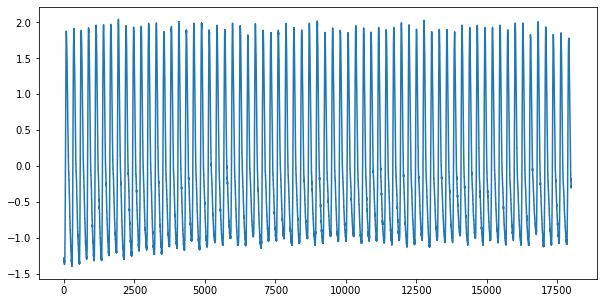

2276


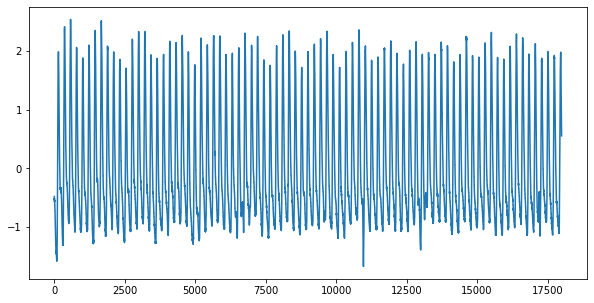

4386


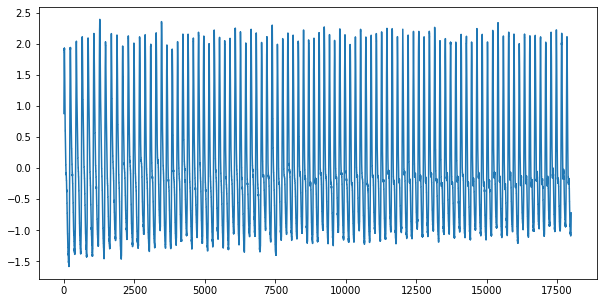

442


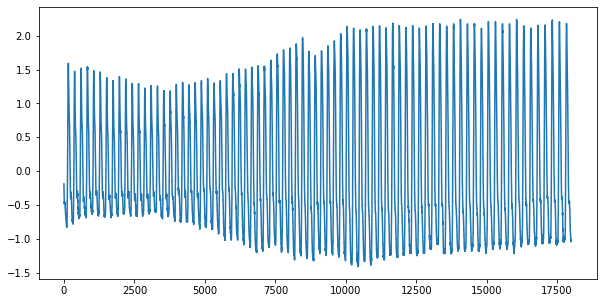

5050


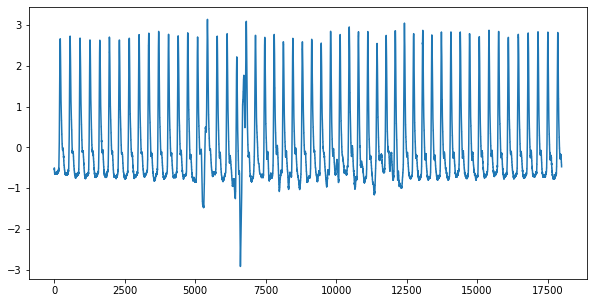

4246


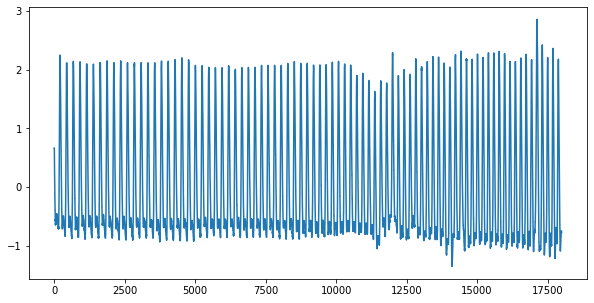

5850


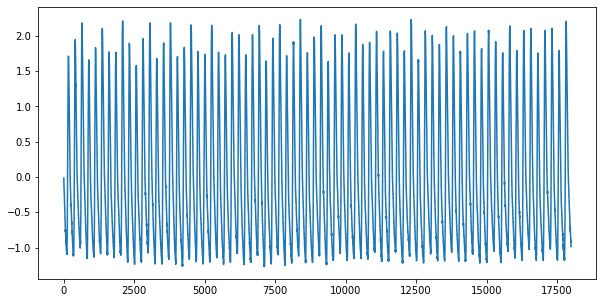

5270


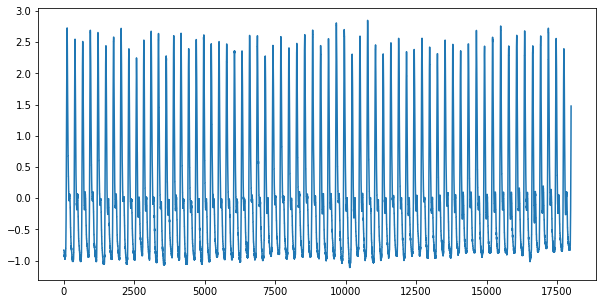

235


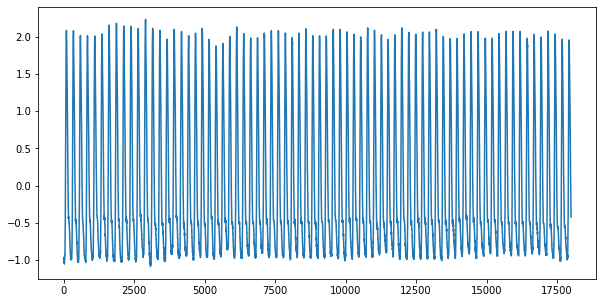

1855


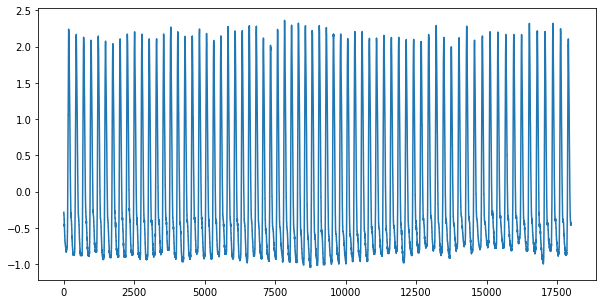

6014


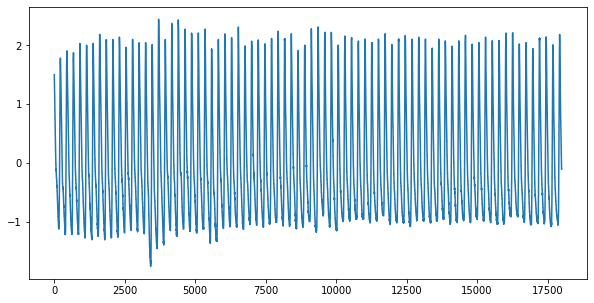

2570


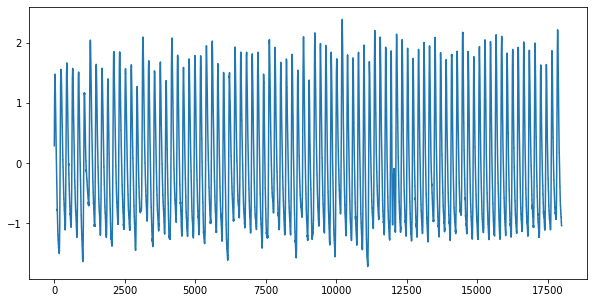

5605


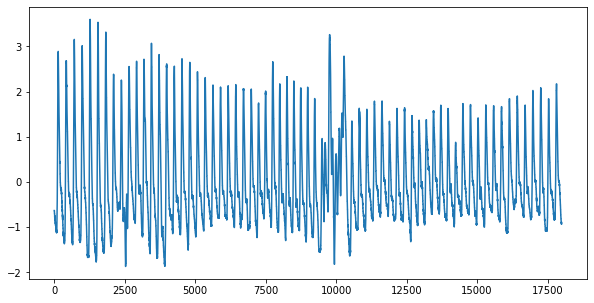

3455


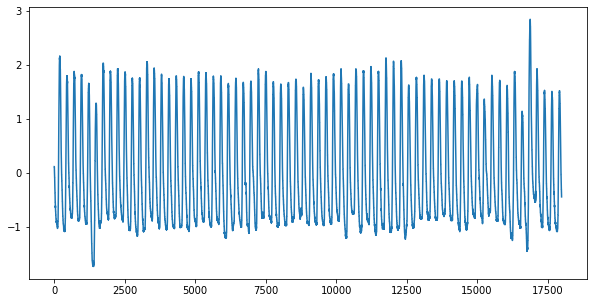

5382


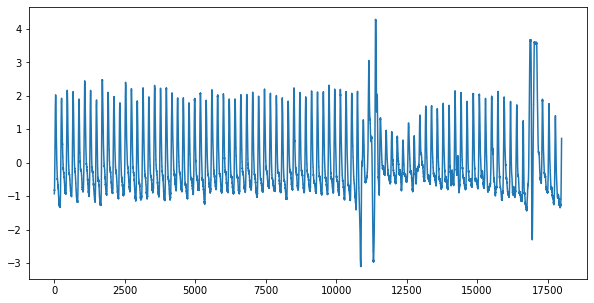

1045


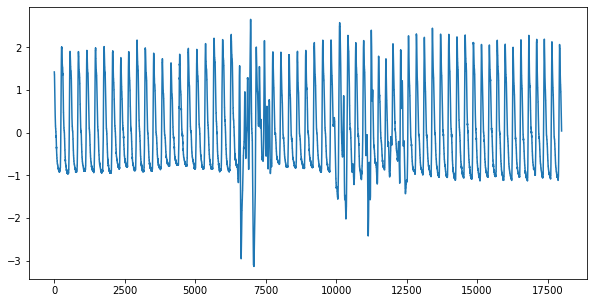

5556


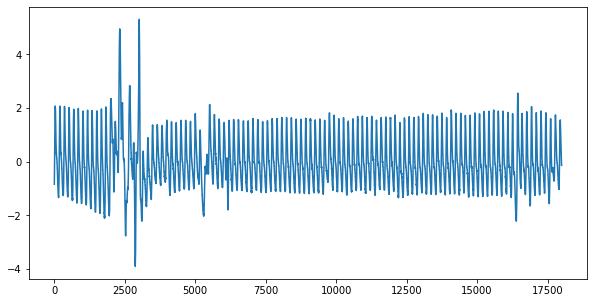

2696


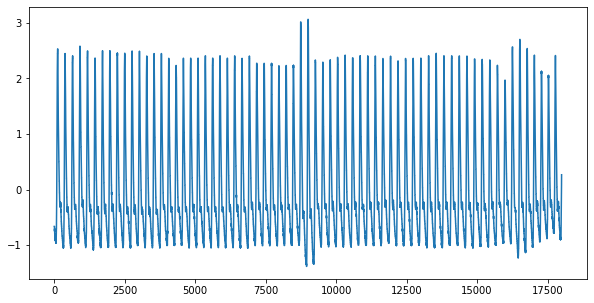

5816


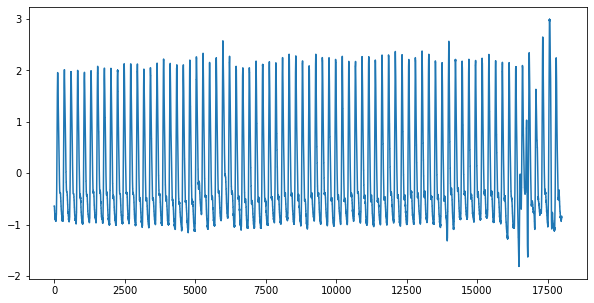

4895


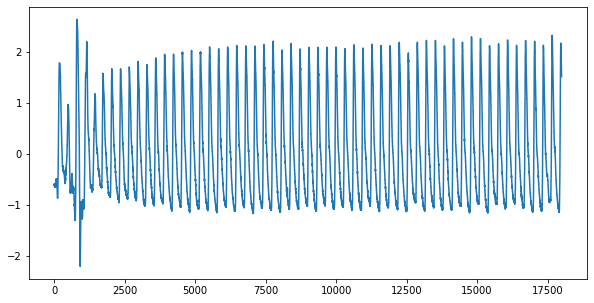

5477


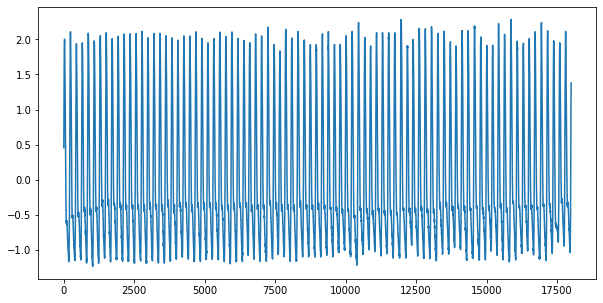

692


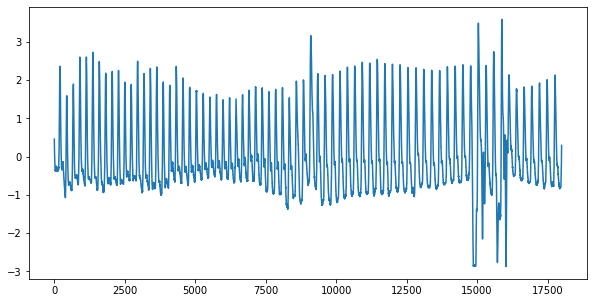

5768


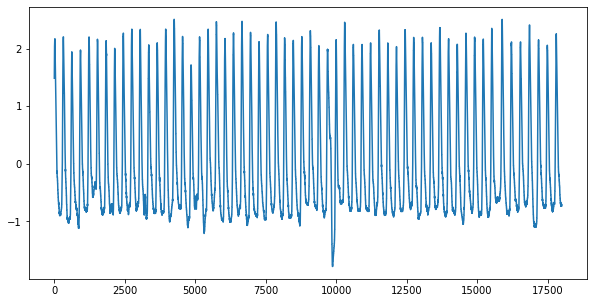

5949


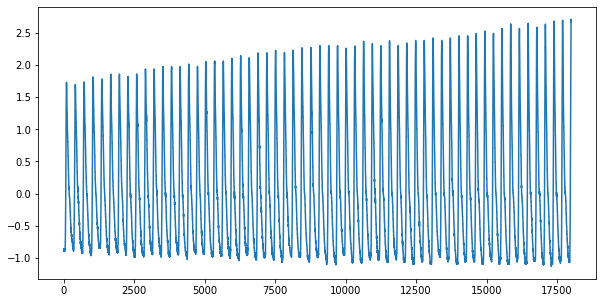

3482


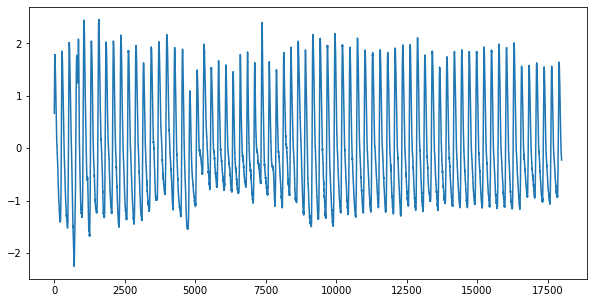

4516


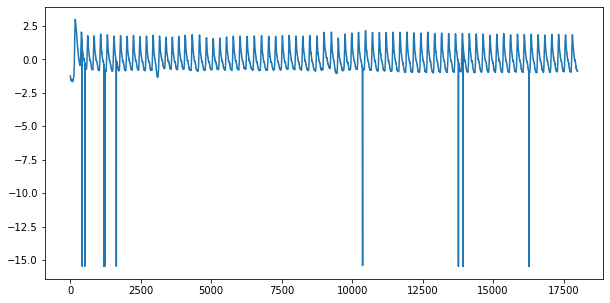

5765


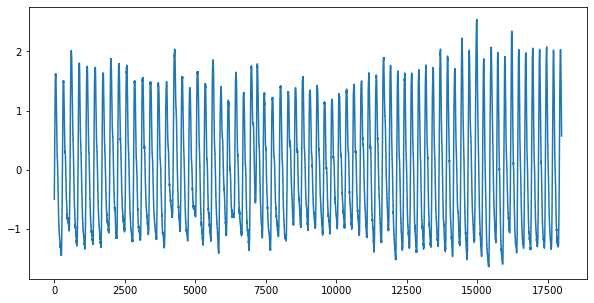

2282


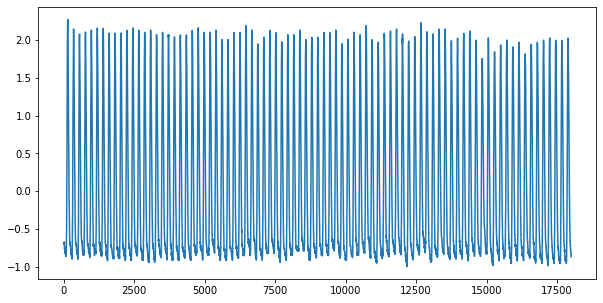

2762


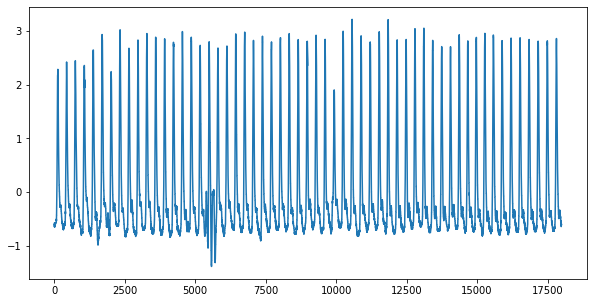

5265


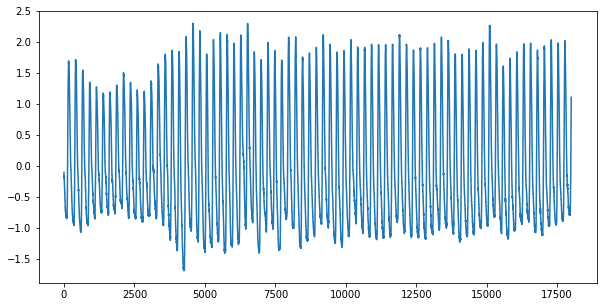

In [7]:
# input validation
import matplotlib.pyplot as plt

#plt.figure(figsize=(20,10))
c_train = np.array(c)[train_mask]

num = 100
for i in range(num,num+30):
    print(c_train[i])
    plt.figure(figsize=(10,5))
    plt.plot(x_train[i,:,0])
    plt.show()

In [12]:
train_w_samp = np.ones(shape=(len(y_train),))
#val_w_samp = np.ones(shape=(len(y_val),))
test_w_samp = np.ones(shape=(len(y_test),))


# folder
nfold = 1  # 각각의 hyperparameter에 대해 k-fold 를 시행하고 평균을 구한다.
ntest = 500
rootdir = f"../DL_model/randomSearch/HR_PD/CNN_HR0.25_Bin_SRATE{SRATE}-PPG-{PPG_FILT}_ECG-{ECG_FILT}_THRES{CORR_THRES}_{nfold}fold_test{ntest}_w_samp0(train)"

if not os.path.exists(rootdir):
    os.mkdir(rootdir)

# 모델에 대한 정보 txt로 저장
f = open(f'{rootdir}/README.txt', 'w')
f.write(f'model: 1D CNN 4 layers, binary classification')
f.write(f'input: ECG,PPG,RFTN of pre-intubation 120~60s, output: del HR 0.25 (post-intubation 0-60s)')
f.close()
    

# test_settings
layer_settings, test_settings = [], []


# hyperparamters
#num_nodes = [64, 64, 64] #, 64, 64, 64]
#kernel_size = 10
pool_size = 2

#dense_node = 32
#dropout_rate = 0.2
learning_rate = 0.001

# hyperparamters pool
filt_opts = [32, 64, 128, 256] # num of filters(kernel)
stride_opts = [1,1,1,1,1,2,2,2,2]
kernel_opts = range(3,9,2) # kernel size
dropout_opts  = [0, 0.1, 0.2, 0.3, 0.4, 0.5] # dropout rate
dense_opts = [0, 8, 16, 32, 64, 128]
globalpool_opts = ['max','ave']
BATCH_SIZE = [512, 1024]

print('start making test settings...', end='', flush=True)
# test settings
nfilt, kernels, strides = [], [], []
for i in range(5):
    nfilt.append(0)
    kernels.append(0)
    strides.append(0)

for nfilter in filt_opts:
    for kernel in kernel_opts:
        for stride in stride_opts:
            layer_settings.append([nfilter, kernel, stride])                
    
for dense_node in dense_opts:
    for dropout_cnn in dropout_opts:
        for dropout_fc in dropout_opts:
            for globalpool_opt in globalpool_opts:
                for batch_size in BATCH_SIZE:
                    for conv_double in [True, False]:
                        for learning_rate in [0.001, 0.002, 0.0005]:
                            test_settings.append([dense_node, dropout_cnn, dropout_fc, globalpool_opt, batch_size, conv_double, learning_rate])                                   

                        
print('done')
print(datetime.datetime.now())

start making test settings...done
2022-11-16 21:53:02.191425


In [ ]:
from keras import metrics


# random search for hyperparameter
ntrial = ntest
train_errs, val_errs = [] ,[]
test_acc, test_roc, test_prc = [], [], []
#test_rmse, test_mae, test_auc = [], [], []
random_settings = []


for itrial in range(ntrial):
    # grid search
    # test_setting = test_settings[itrial]

    # random search
    print('random search {}/{}'.format(itrial, ntrial))
    
    # total conv layers of the model
    n_conv = random.choice([2,3,4]) 
    # test settings
    for i in range(n_conv):
        nfilt[i], kernels[i], strides[i] = random.choice(layer_settings)
    dense_node, dropout_cnn, dropout_fc, globalpool_opt, batch_size, conv_double, learning_rate = random.choice(test_settings)
    

    # 이번 옵션에 대한 결과 디렉토리
    odir_f = f'batch{batch_size},'
    for i in range(n_conv):
        odir_f += f'layer{i+1}:c{nfilt[i]}filt{kernels[i]}str{strides[i]},'
    odir_f += f'globalpool={globalpool_opt},dropout{dropout_cnn},dnodes{dense_node},dropout{dropout_fc}'#,lr{learning_rate}'
    random_settings.append(odir_f)
    
    odir = rootdir + '/' + odir_f
    if not os.path.exists(odir):
        os.mkdir(odir)

    weightcache = "{}/weights.hdf5".format(odir)        

    
    with tf.device('/gpu:3'):
        # build a model
        act='relu'

        inp = Input(shape=(x_train.shape[1],3))
        out = inp
        
        for i in range(n_conv):
            out = Conv1D(filters=nfilt[i], kernel_size=kernels[i], strides=strides[i], padding='same')(out)
            out = BatchNormalization()(out)
            out = MaxPooling1D(pool_size)(out)
                  


        # global이냐 flatten이냐는 따로 모델 나눠야 할듯
        if globalpool_opt == 'max':
            out = GlobalMaxPooling1D()(out)
        elif globalpool_opt == 'ave':
            out = GlobalAveragePooling1D()(out)


        if dense_node != 0:
            out = Dropout(dropout_cnn)(out)
            out = Dense(dense_node, activation='tanh')(out)
        out = Dropout(dropout_fc)(out)
        out = Dense(1, activation='sigmoid')(out)
        
        
        model = Model(inputs=[inp], outputs=[out])

        # model 학습 설정
        try:
            #optimizer = Adam(lr=learning_rate)
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["acc", tf.keras.metrics.AUC()])
            hist = model.fit(input_train, y_train_bin, sample_weight=train_w_samp, validation_split=0.2, epochs=100, batch_size=batch_size, #class_weight={0:1, 1:3}, 
                                    callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weightcache, verbose=1, save_best_only=True),
                                                EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='auto')])
        except Exception as e:
            print(e)
            os.rmdir(odir)
            #os.rename(odir,rootdir+'/error_{}'.format(odir_f))
            itrial -= 1
            test_roc.append(0)
            test_acc.append(0)
            test_prc.append(0)
            train_errs.append(-1)
            val_errs.append(-1)
            continue
            
            
    # 모델의 아키텍처 및 구조 저장
    open(odir+"/model.json", "wt").write(model.to_json())

    # test set에 대한 y_pred 계산
    model.load_weights(weightcache)  # fit 함수는 마지막 epoch의 결과를 리턴하기 때문에 best 결과를 다시 읽어들어야함
    y_pred = model.predict(input_test).flatten()

    
    # acc 계산
    acc = metrics.Accuracy()
    acc.update_state(y_pred>=0.5, y_test_bin, sample_weight=test_w_samp)
    acc_val = acc.result().numpy()
    test_acc.append(acc_val)
    
    # auroc 계산
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test_bin, y_pred, sample_weight=test_w_samp)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_roc.append(roc_auc)

    # auprc 
    precision, recall, _ = precision_recall_curve(y_test_bin, y_pred, sample_weight=test_w_samp)
    prc_auc = auc(recall, precision)
    test_prc.append(prc_auc)

    
    # rename
    os.rename(odir, rootdir+'/roc{:.4f}_prc{:.4f}_{}_acc{:.2f}'.format(roc_auc, prc_auc, odir_f, acc_val))

    # train 과정에서의 err
    train_err = min(hist.history['loss'])
    val_err = min(hist.history['val_loss'])

    val_errs.append(val_err)
    train_errs.append(train_err)


    tf.keras.backend.clear_session()


max_idx = test_roc.index(max(test_roc))
print('\nBest Model roc:{:.4f}, info: {}'.format(test_roc[max_idx], random_settings[max_idx]))


random search 0/500
Epoch 1/100
1/1 [==============================] - 6s 6s/step - loss: 0.7685 - acc: 0.4905 - auc: 0.5095 - val_loss: 0.9091 - val_acc: 0.5708 - val_auc: 0.4882

Epoch 00001: val_loss improved from inf to 0.90907, saving model to ../DL_model/randomSearch/HR_PD/CNN_HR0.25_Bin_SRATE300-PPG-lowess_ECG-bandpass_THRES0.9_1fold_test500_w_samp0(train)/batch1024,layer1:c128filt3str2,layer2:c128filt7str2,layer3:c256filt5str2,globalpool=ave,dropout0.2,dnodes128,dropout0.4/weights.hdf5
Epoch 2/100
1/1 [==============================] - 1s 725ms/step - loss: 1.0523 - acc: 0.6031 - auc: 0.5063 - val_loss: 0.6930 - val_acc: 0.5566 - val_auc: 0.5104

Epoch 00002: val_loss improved from 0.90907 to 0.69295, saving model to ../DL_model/randomSearch/HR_PD/CNN_HR0.25_Bin_SRATE300-PPG-lowess_ECG-bandpass_THRES0.9_1fold_test500_w_samp0(train)/batch1024,layer1:c128filt3str2,layer2:c128filt7str2,layer3:c256filt5str2,globalpool=ave,dropout0.2,dnodes128,dropout0.4/weights.hdf5
Epoch 3/100
1/1

2022-11-16 22:02:15.438359: W tensorflow/core/common_runtime/bfc_allocator.cc:271] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.83GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-11-16 22:02:26.450092: W tensorflow/core/common_runtime/bfc_allocator.cc:456] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.62GiB (rounded to 3890016256)requested by op gradient_tape/model/conv1d_1/conv1d/Conv2DBackpropInput
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-11-16 22:02:26.450165: I tensorflow/core/common_runtime/bfc_allocator.cc:991] BFCAllocator dump for GPU_0_bfc
2022-11-16 22:02:26.450192: I tensorflow/core/common_runtime/bfc_allocator.cc:998] Bin (256): 	Total Chunks: 182, Chunks in use: 1

 OOM when allocating tensor with shape[844,256,1,4501] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/model/conv1d_1/conv1d/Conv2DBackpropInput (defined at usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/optimizer_v2.py:456) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_58646]

Errors may have originated from an input operation.
Input Source operations connected to node gradient_tape/model/conv1d_1/conv1d/Conv2DBackpropInput:
 model/conv1d_1/conv1d/ExpandDims_1 (defined at usr/local/lib/python3.8/dist-packages/keras/layers/convolutional.py:245)

Function call stack:
train_function

random search 6/500
Epoch 1/100
1/1 [==============================] - 6s 6s/step - loss: 0.6932 - acc: 0.5604 - auc_1: 0.5286 - val_loss: 0.6850 - val_acc: 0.5708 - val_auc_1: 0.5183

Epoch 00001: 

2022-11-16 22:03:01.184186: W tensorflow/core/common_runtime/bfc_allocator.cc:456] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.62GiB (rounded to 3889152000)requested by op gradient_tape/model/max_pooling1d_1/MaxPool/MaxPoolGrad-0-TransposeNHWCToNCHW-LayoutOptimizer
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-11-16 22:03:01.184273: I tensorflow/core/common_runtime/bfc_allocator.cc:991] BFCAllocator dump for GPU_0_bfc
2022-11-16 22:03:01.184302: I tensorflow/core/common_runtime/bfc_allocator.cc:998] Bin (256): 	Total Chunks: 306, Chunks in use: 304. 76.5KiB allocated for chunks. 76.0KiB in use in bin. 13.0KiB client-requested in use in bin.
2022-11-16 22:03:01.184320: I tensorflow/core/common_runtime/bfc_allocator.cc:998] Bin (512): 	Total Chunks: 56, Chunks in use: 56. 28.2KiB allocated for chunks. 28.2KiB

2 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[844,128,9000,1] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/model/max_pooling1d_1/MaxPool/MaxPoolGrad-0-TransposeNHWCToNCHW-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[assert_less_equal/Assert/AssertGuard/pivot_f/_13/_61]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  OOM when allocating tensor with shape[844,128,9000,1] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/model/max_pooling1d_1/MaxPool/MaxPoolGrad-0-TransposeNHWCToNCHW-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when 